# MLP and Data analysis for a blood-cell Classification Data set


### Background

In the study of leukemia, accurately classifying blood cell types is crucial for understanding how different substances influence their distribution. Automating this classification process is essential to handle large volumes of data efficiently, reducing the need for extensive manual effort.

This project involves analyzing blood samples stained with Giemsa and captured using an automated microscope. The images have been preprocessed to segment individual cells using an advanced segmentation pipeline ([Cellpose](https://www.cellpose.org)). Segmentation maps were generated to isolate regions corresponding to classified cells from the background and neighboring cells.

Further, cell-related features were extracted using *FIJI / ImageJ* ([ImageJ](https://imagej.net/ij/index.html)). These features are documented in detail here: [ImageJ Measurements](https://imagejdocu.list.lu/gui/analyze/set_measurements). The data is compiled into two datasets, `bloodcells_train.csv` and `bloodcells_test.csv`.

### Approach

To classify the blood cells accurately, various machine learning models were compared, including a custom-implemented Multi-Layer Perceptron (MLP). The focus was on optimizing these models to achieve high classification accuracy and robustness.

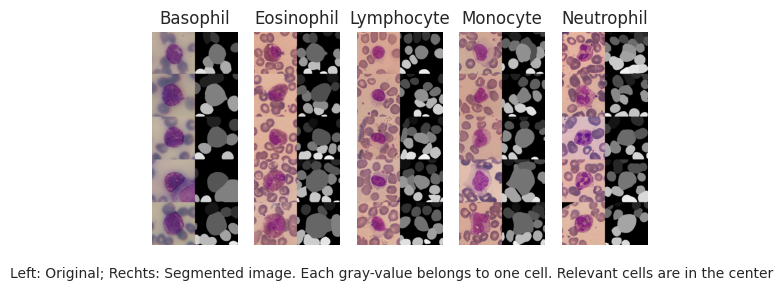

In [2]:
from IPython.display import Image
from PIL import Image as PILImage
import matplotlib.pyplot as plt

img1 = PILImage.open('data/Basophil.png')
img2 = PILImage.open('data/Eosinophil.png')
img3 = PILImage.open('data/Lymphocyte.png')
img4 = PILImage.open('data/Monocyte.png')
img5 = PILImage.open('data/Neutrophil.png')

# Subplots
fig, ax = plt.subplots(1,5)

ax[0].imshow(img1)
ax[0].axis('off') 
ax[0].set_title('Basophil') 
ax[1].imshow(img2)
ax[1].axis('off')
ax[1].set_title('Eosinophil')
ax[2].imshow(img3)
ax[2].axis('off') 
ax[2].set_title('Lymphocyte')
ax[3].imshow(img4)
ax[3].axis('off') 
ax[3].set_title('Monocyte')
ax[4].imshow(img5)
ax[4].axis('off') 
ax[4].set_title('Neutrophil')

fig.text(0.5, 0.2, 'Left: Original; Right: Segmented image. Each gray-value belongs to one cell. Relevant cells are in the center', ha='center', va='bottom')
plt.show()



### Getting an overview of training data

#-----------------------df.head()--------------------------#
         image filename   Area  Mean red  StdDev red  Mode red  Min red  \
0  95-5-10-1_231_1.jpg   36063   101.964      49.394        37       20   
1   95-9-4-4_121_1.jpg    6432    97.806      41.106        53       39   
2   95-5-4-1_182_1.jpg   32524   156.996      23.149       157      100   
3   95-8-13-3_60_2.jpg   25293   124.220      47.617        81       54   
4  95-5-10-1_645_2.jpg   44853   167.199      58.149       219       52   

   Max red   Perim.  Circ.    Feret  ...  Min green  Max blue  Max green  \
0      187  774.767  0.755  260.967  ...          0       183        162   
1      190  329.765  0.743  121.672  ...          2       161        127   
2      251  717.696  0.793  252.242  ...         24       186        193   
3      217  609.955  0.854  213.328  ...          0       180        171   
4      239  815.151  0.848  257.329  ...          1       202        181   

   Median blue  Median green  S

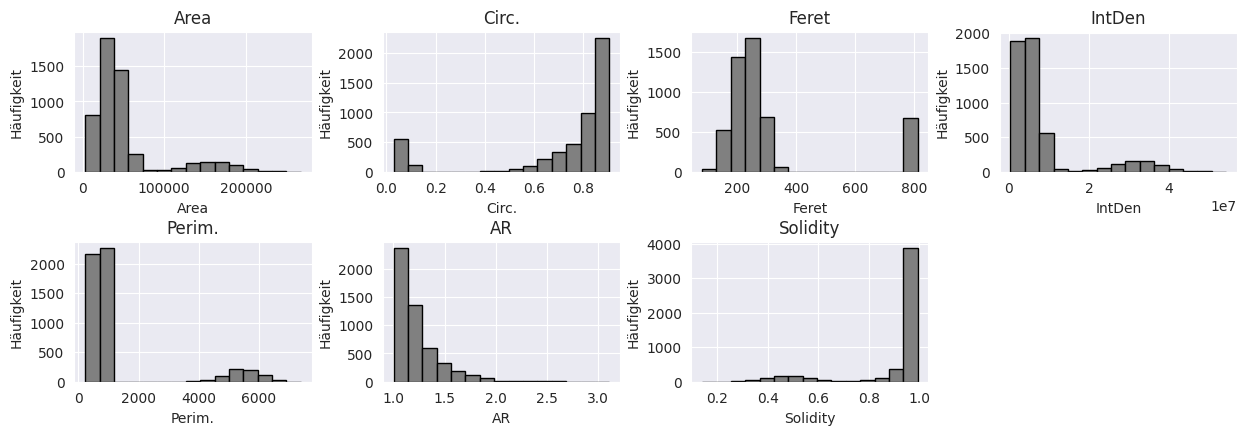

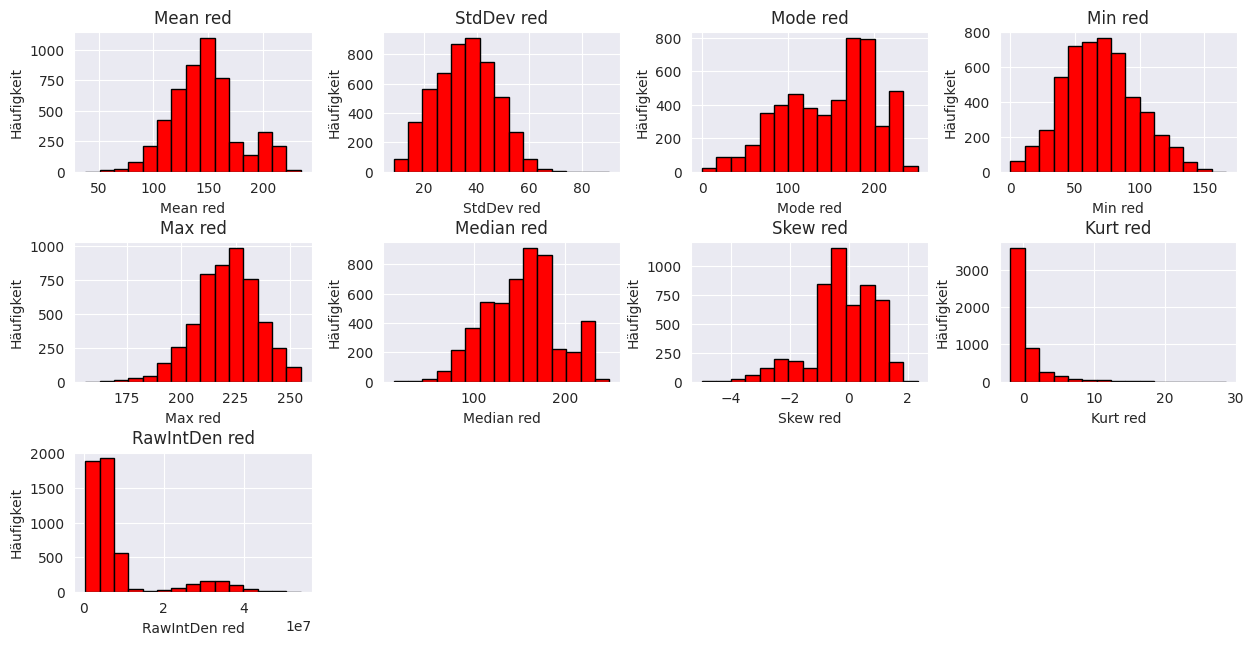

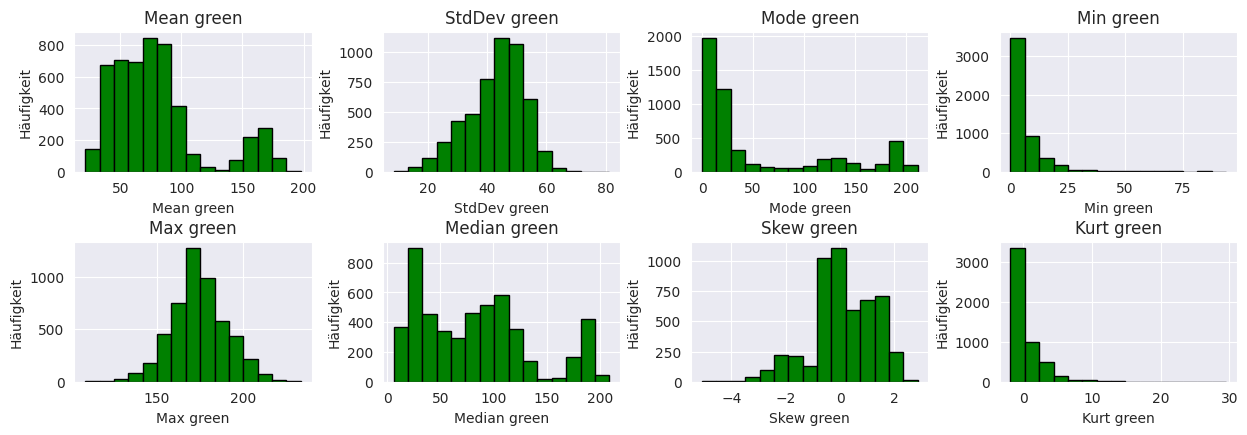

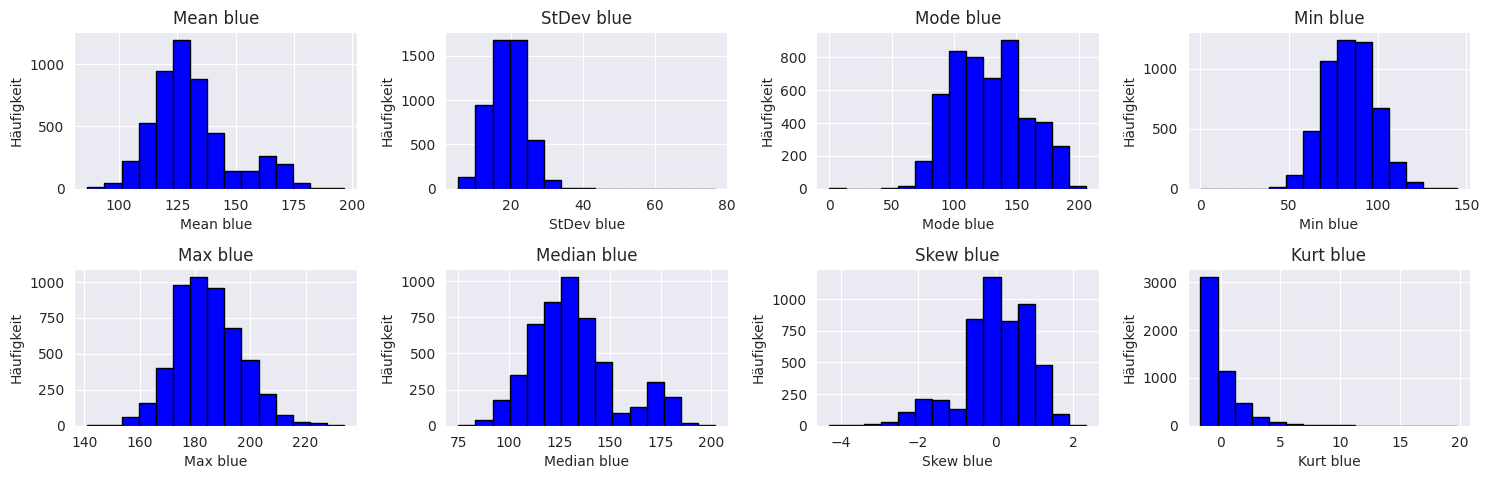

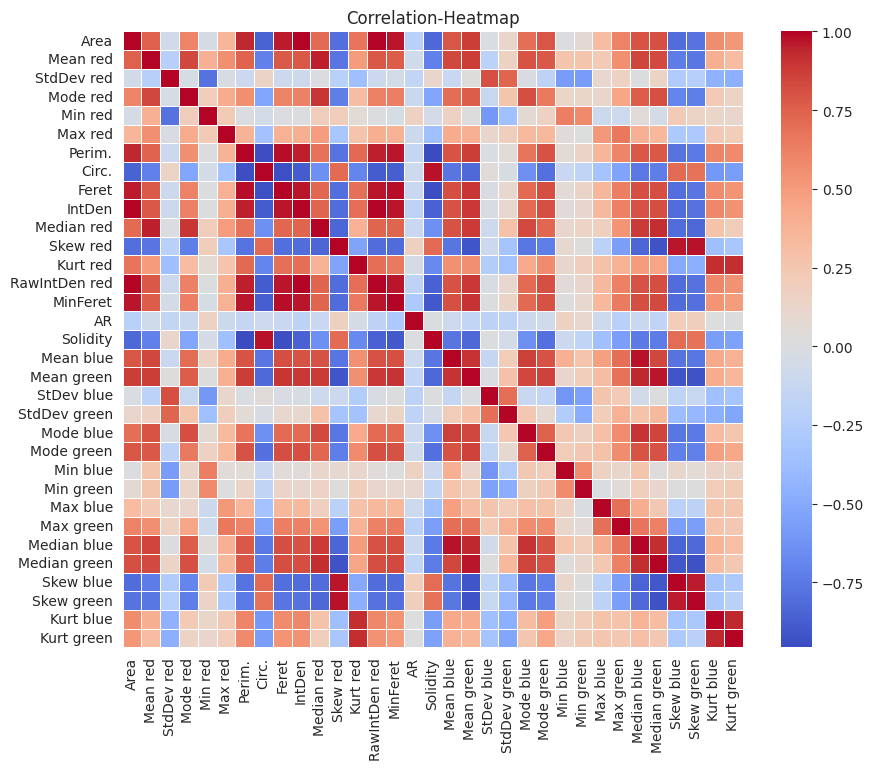

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/bloodcells_train.csv', delimiter=";")
#print(df.isnull().sum())


print("#-----------------------df.head()--------------------------#")
print(df.head())
print("#-----------------------df.info()--------------------------#")
print(df.info())
print("#-----------------------df.describe()--------------------------#")
print(df.describe())
print("#-----------------------Class value counts--------------------------#")
print(df['Class'].value_counts())



#----------------------Histogramme--------------------------#
def plot_histograms(features, color):
    df[features].hist(bins=15, figsize=(15, 10), layout=(4, 4), color=color, edgecolor='black')
    for i, ax in enumerate(plt.gcf().axes):
        if i < len(features):
            ax.set_xlabel(features[i])
            ax.set_ylabel('Häufigkeit')
        else:
            ax.set_visible(False)
    plt.subplots_adjust(hspace=0.5)

def plot_heatmap(features):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[features].corr(), annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation-Heatmap')
    plt.show()

#----------------------Features general--------------------------#
general_features = ['Area', 'Circ.', 'Feret', 'IntDen', 'Perim.', 'AR', 'Solidity']
plot_histograms(general_features, 'grey')

#----------------------Features red--------------------------#
red_features = [col for col in df.columns if 'red' in col]
plot_histograms(red_features, 'red')

#----------------------Features green--------------------------#
green_features = [col for col in df.columns if 'green' in col]
plot_histograms(green_features, 'green')

#----------------------Features blue--------------------------#
blue_features = [col for col in df.columns if 'blue' in col]
plot_histograms(blue_features, 'blue')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#----------------------Heatmap--------------------------#
heat_features = df.drop(columns=['Class', 'image filename']).columns
plot_heatmap(heat_features)

**Blue Features**:

The distributions of "Mean blue," "Max blue," and "Median blue" are nearly normally distributed.
"Min blue" and "Skew blue" show a left-skewed distribution, indicating that most values are lower, with some high outliers.
"Kurt blue" shows a distribution with a long right tail, indicating high peak formation.

**Green Features**:

"Mean green" and "Median green" show a multimodal distribution, indicating the presence of multiple subgroups within the dataset.
"StdDev green" and "Max green" are almost normally distributed, while "Min green" is highly left-skewed.
"Skew green" and "Kurt green" exhibit a distribution with high peak formation and elongated tails.

**Red Features**:

The distributions of "Mean red," "Max red," and "Median red" are nearly normal.
"Mode red" shows a slightly right-skewed distribution, while "Min red" shows a left-skewed distribution.
"RawIntDen red" has a highly right-skewed distribution with many low values and a few high outliers.

**General Features**:

"Area," "Perim.," and "IntDen" show a highly left-skewed distribution, indicating that most values are low, but there are some high outliers.
"Circ." and "Solidity" are highly right-skewed, meaning most values are high, but there are some low outliers.
"Feret" and "AR" show distributions with multiple peaks, indicating the presence of several subgroups within the dataset.

**The Correlation Matrix** shows the relationships between different features of the dataset for blood cell classification. Strong positive correlations, such as those between various color features (e.g., `Mean red`, `Max red`, `Median red`), suggest that these features provide similar information about the cells. Negative correlations, like those between `Circ.` (Circularity) and `Area`, indicate that larger cells tend to be less circular. Overall, the matrix helps identify redundant features, which is useful for feature selection and model optimization.

**Modeling Expectations for Class:**

Multiclassification: Since Class represents a categorization of blood cells (Neutrophil, Lymphocyte, Eosinophil, Monocyte, Basophil), a multiclass classification model will be required.

Feature Selection: Features such as area, perimeter, Feret diameter, and color values seem promising for distinguishing between cell classes.

Data Balance: The distribution of classes is highly imbalanced, indicating an imbalance (e.g., more Neutrophils than Basophils). Techniques like oversampling or undersampling may be necessary.

**Dataset Preparation:**

- Data Cleaning: Although there are no missing values in the dataset, there may be outliers that need to be removed. It is particularly important not to generally look for outliers in features but to consider the distribution for each feature and each class individually, given the highly asymmetric class distribution.
  
- Feature Engineering: There are already many features, so it may not be necessary to create additional ones, but one-hot encoding for the classes might be needed.
  
- Data Splitting: It may not be necessary to split the data, as we already have pre-split (train/test) data.
  
- Feature Scaling: Since the features have different scales, it will likely be necessary to scale the features.
  
- Data Balance: Depending on the model, techniques to address class imbalance (e.g., SMOTE) may be required.

### Evaluation of Test Data

#-----------------------df.head()--------------------------#
         image filename   Area  Mean red  StdDev red  Mode red  Min red  \
0  95-5-10-1_231_1.jpg   36063   101.964      49.394        37       20   
1   95-9-4-4_121_1.jpg    6432    97.806      41.106        53       39   
2   95-5-4-1_182_1.jpg   32524   156.996      23.149       157      100   
3   95-8-13-3_60_2.jpg   25293   124.220      47.617        81       54   
4  95-5-10-1_645_2.jpg   44853   167.199      58.149       219       52   

   Max red   Perim.  Circ.    Feret  ...  Min green  Max blue  Max green  \
0      187  774.767  0.755  260.967  ...          0       183        162   
1      190  329.765  0.743  121.672  ...          2       161        127   
2      251  717.696  0.793  252.242  ...         24       186        193   
3      217  609.955  0.854  213.328  ...          0       180        171   
4      239  815.151  0.848  257.329  ...          1       202        181   

   Median blue  Median green  S

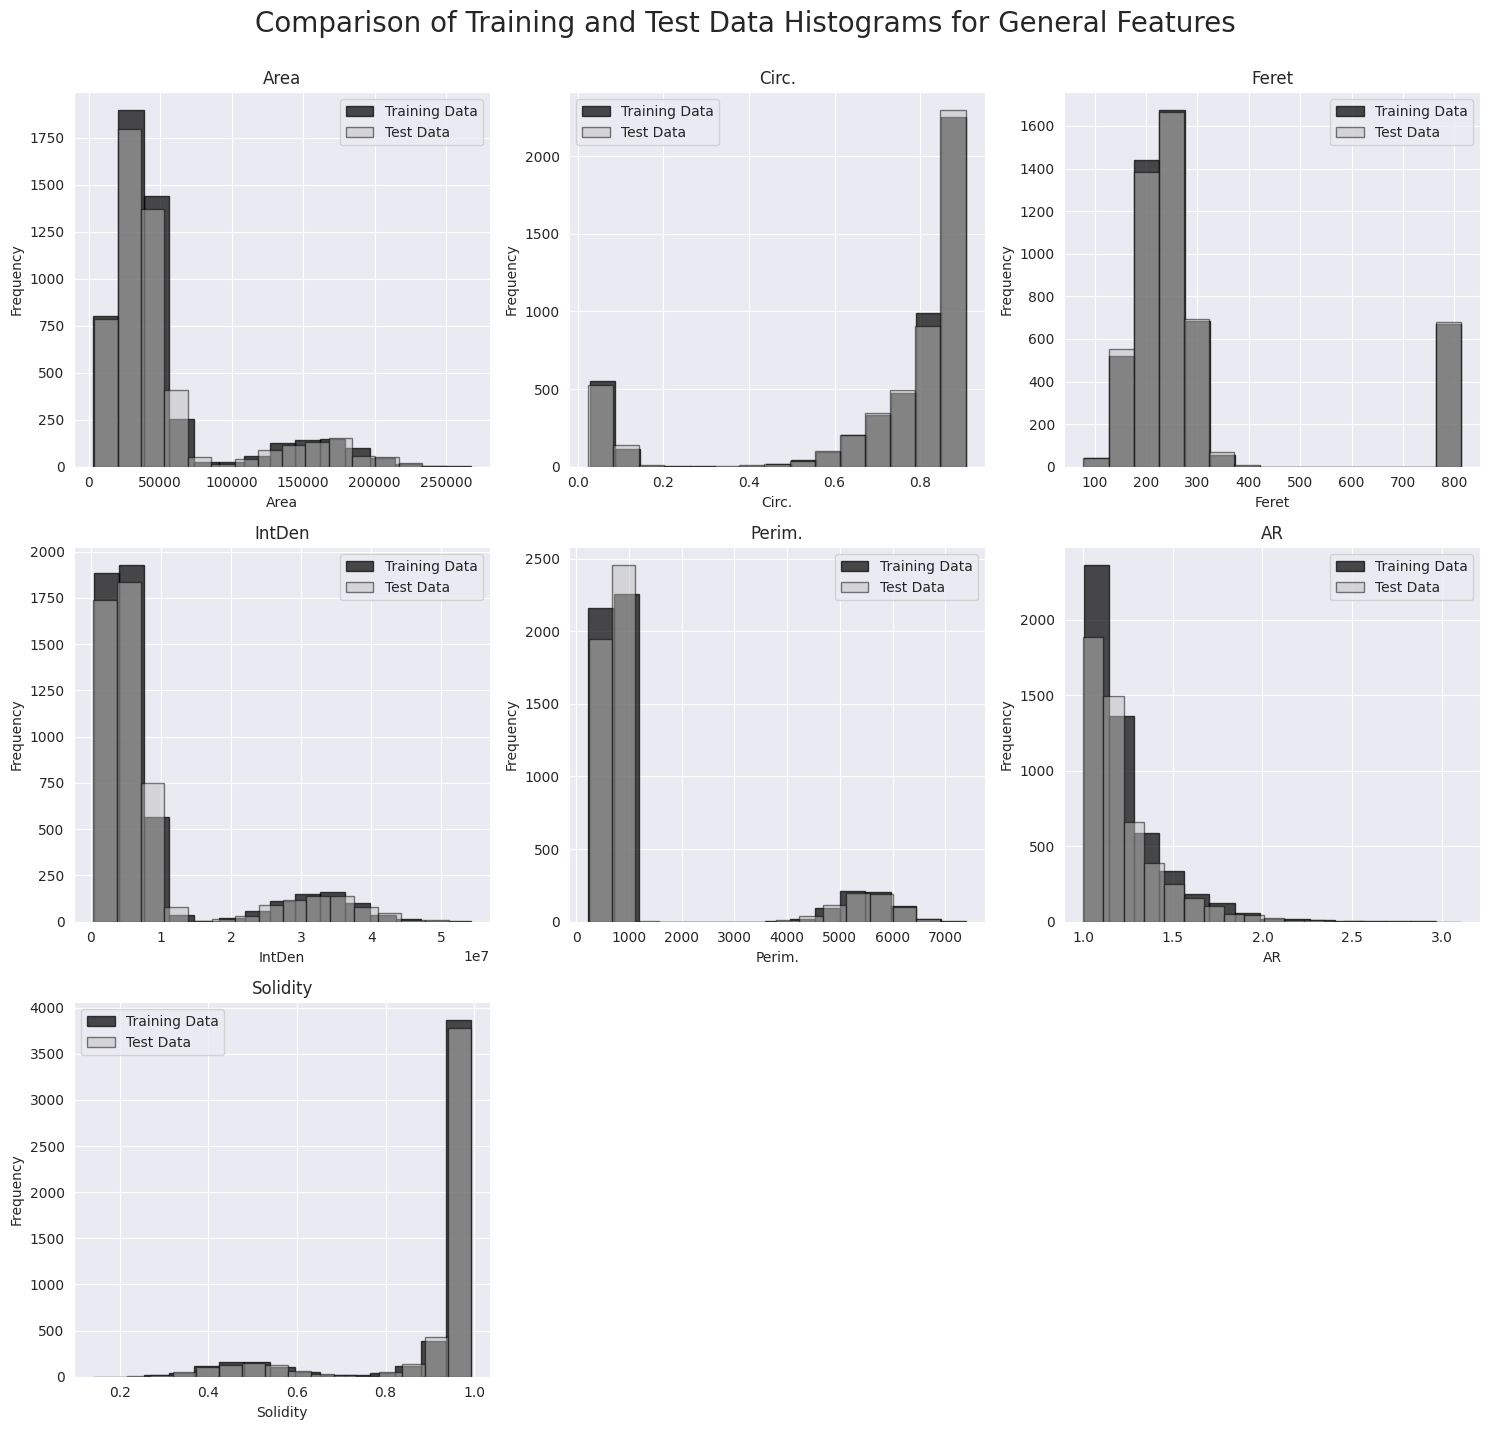

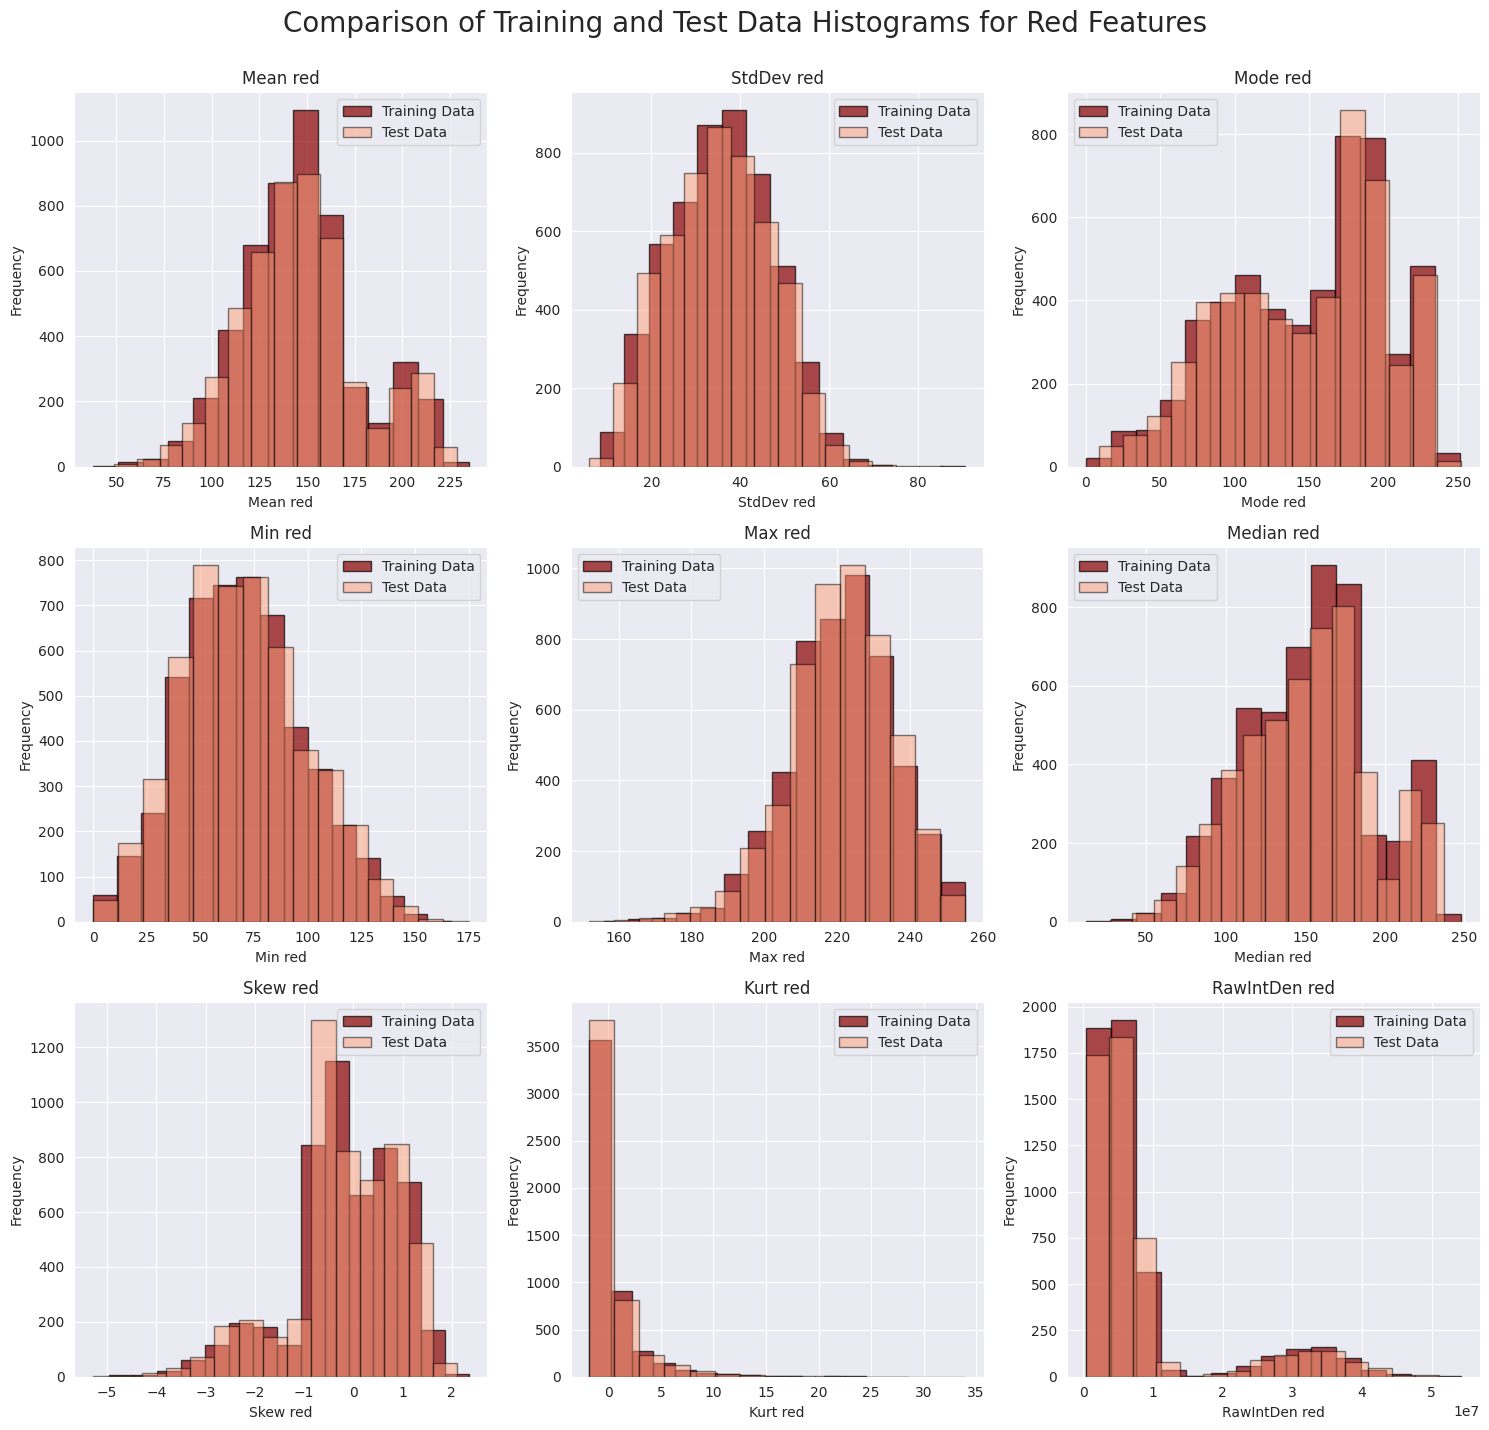

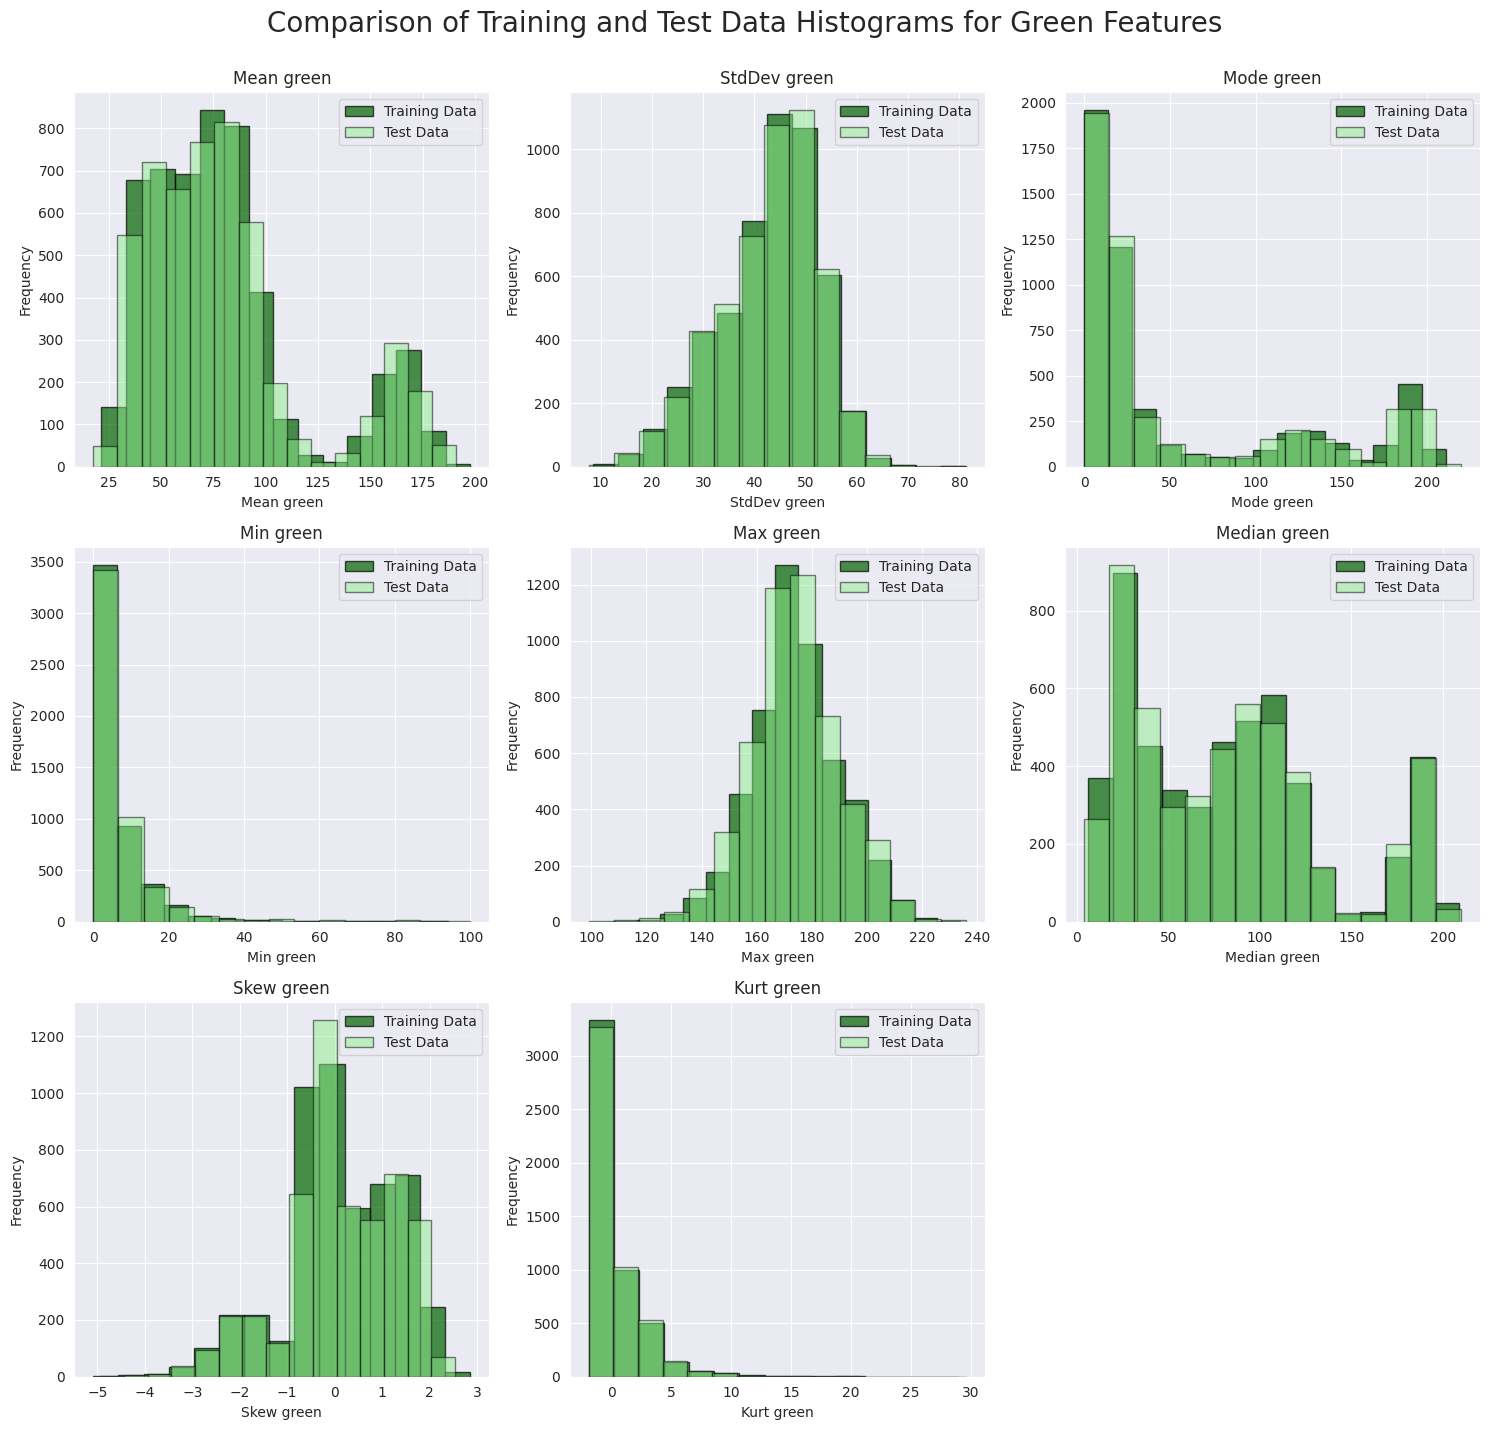

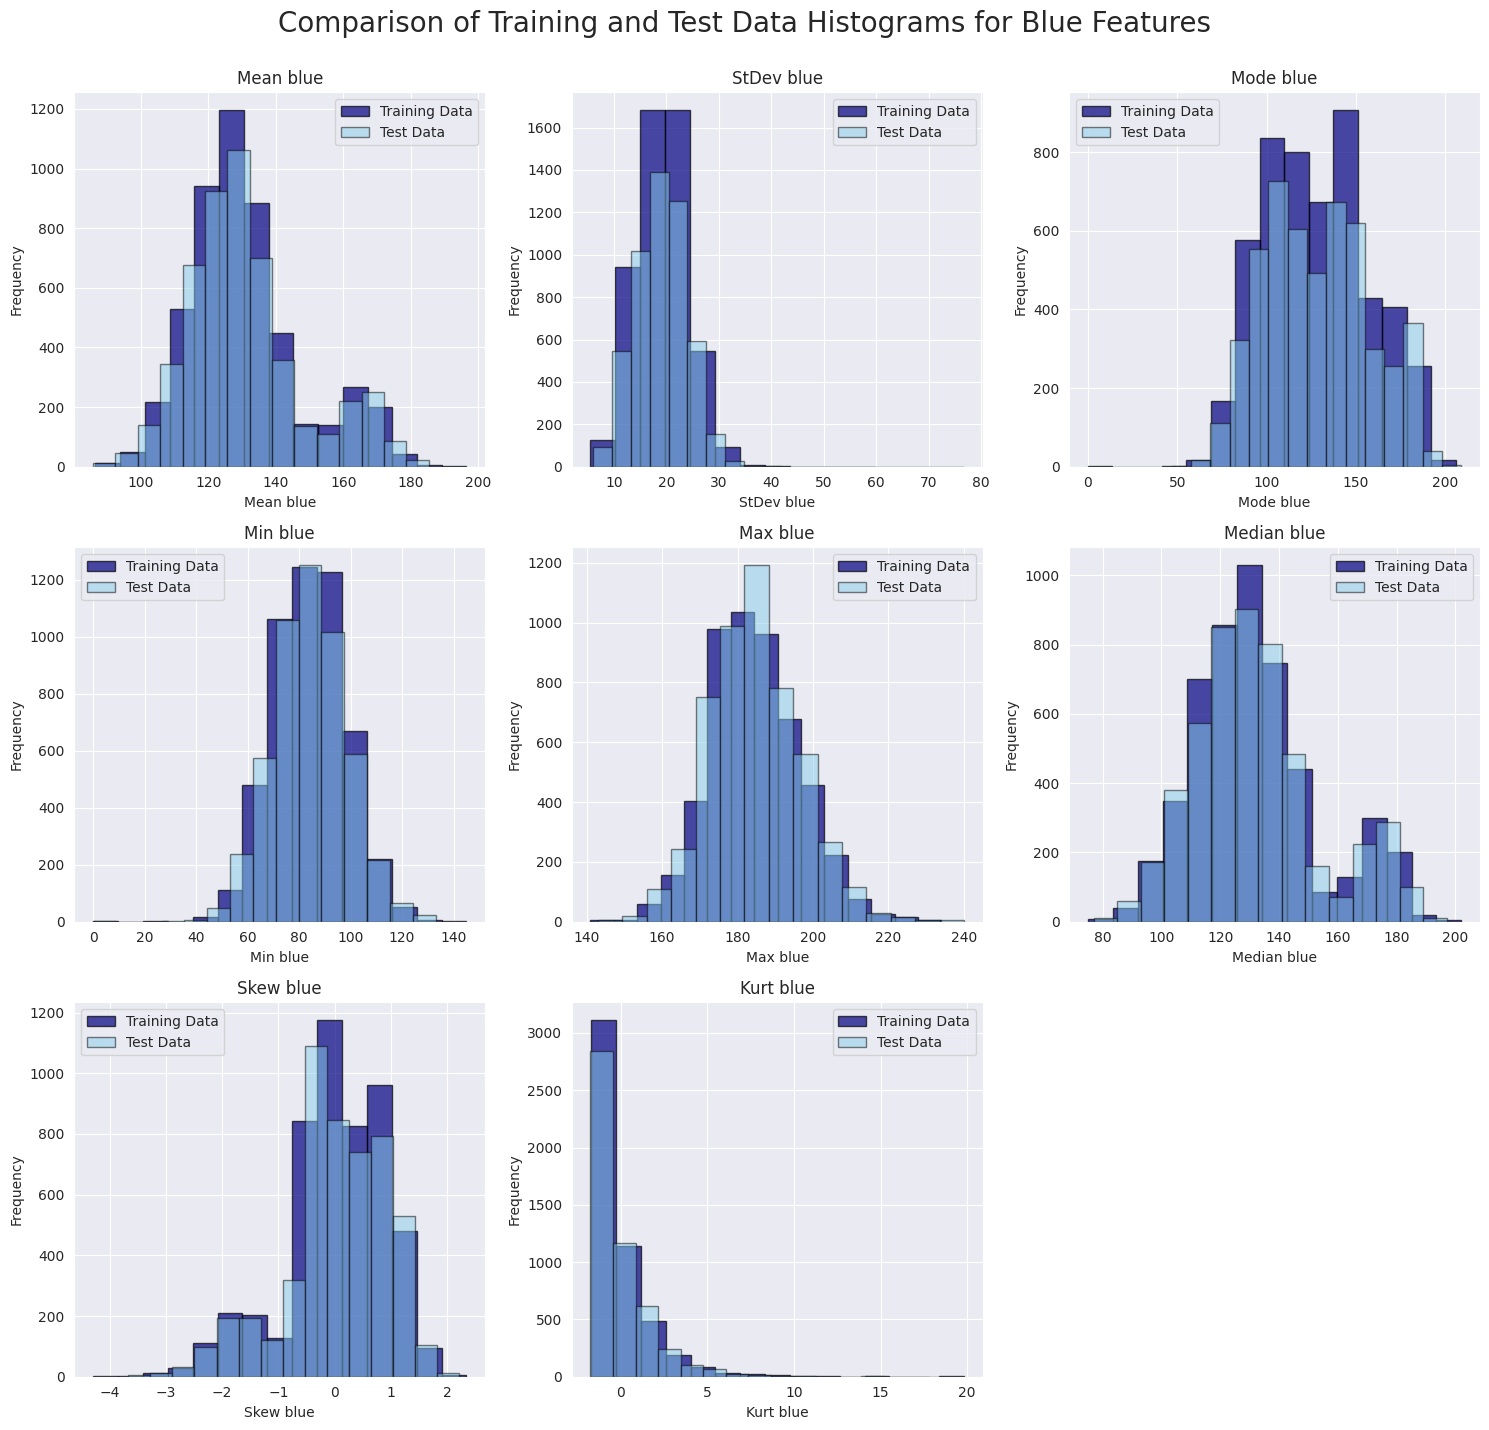

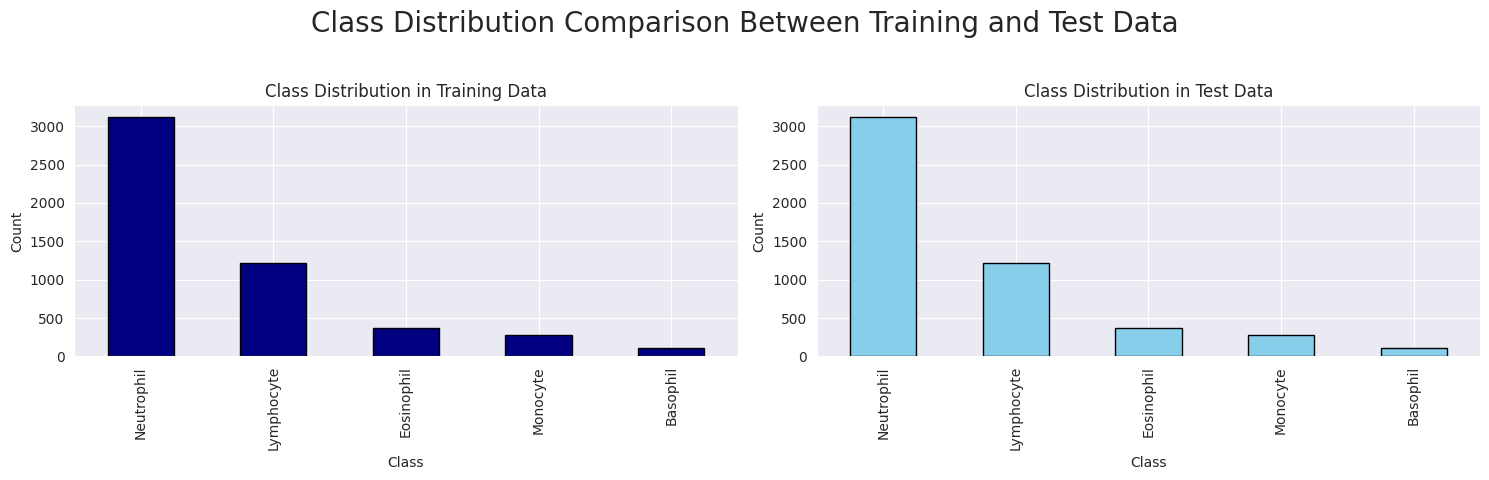

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/bloodcells_train.csv', delimiter=";")
dft = pd.read_csv('data/bloodcells_test.csv', delimiter=";")

print("#-----------------------df.head()--------------------------#")
print(df.head())
print("#-----------------------df.info()--------------------------#")
print(df.info())
print("#-----------------------df.describe()--------------------------#")
print(df.describe())
print("#-----------------------Class value counts--------------------------#")
print(df['Class'].value_counts())

def plot_histograms_comparison(features, df1, df2, df1_label, df2_label, df1_color, df2_color, ncols=3):
    nrows = (len(features) + ncols - 1) // ncols  # Calculate number of rows needed
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    
    axes = axes.flatten()
    for i, feature in enumerate(features):
        axes[i].hist(df1[feature], bins=15, alpha=0.7, label=df1_label, color=df1_color, edgecolor='black')
        axes[i].hist(df2[feature], bins=15, alpha=0.5, label=df2_label, color=df2_color, edgecolor='black')
        axes[i].set_title(f'{feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()
    
    # Hide any unused subplots
    for i in range(len(features), len(axes)):
        axes[i].set_visible(False)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, axes

#----------------------------------PLOT general features  test vs train-----------------------------------
general_features = ['Area', 'Circ.', 'Feret', 'IntDen', 'Perim.', 'AR', 'Solidity']
fig, axes = plot_histograms_comparison(general_features, df, dft, 'Training Data', 'Test Data', 'black', 'silver', ncols=3)
fig.suptitle('Comparison of Training and Test Data Histograms for General Features', fontsize=20)
plt.show()

#----------------------------------PLOT red features test vs train-----------------------------------
red_features = [col for col in df.columns if 'red' in col]
fig, axes = plot_histograms_comparison(red_features, df, dft, 'Training Data', 'Test Data', 'darkred', 'lightsalmon', ncols=3)
fig.suptitle('Comparison of Training and Test Data Histograms for Red Features', fontsize=20)
plt.show()

#----------------------------------PLOT green features test vs train-----------------------------------
green_features = [col for col in df.columns if 'green' in col]
fig, axes = plot_histograms_comparison(green_features, df, dft, 'Training Data', 'Test Data', 'darkgreen', 'lightgreen', ncols=3)
fig.suptitle('Comparison of Training and Test Data Histograms for Green Features', fontsize=20)
plt.show()

#----------------------------------PLOT blue features test vs train-----------------------------------
blue_features = [col for col in df.columns if 'blue' in col]
fig, axes = plot_histograms_comparison(blue_features, df, dft, 'Training Data', 'Test Data', 'navy', 'skyblue', ncols=3)
fig.suptitle('Comparison of Training and Test Data Histograms for Blue Features', fontsize=20)
plt.show()

#-----------------------------Class Distribution Comparison------------------------------
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df['Class'].value_counts().plot(kind='bar', ax=ax[0], color='navy', edgecolor='black')
ax[0].set_title('Class Distribution in Training Data')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

dft['Class'].value_counts().plot(kind='bar', ax=ax[1], color='skyblue', edgecolor='black')
ax[1].set_title('Class Distribution in Test Data')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.suptitle('Class Distribution Comparison Between Training and Test Data', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Suitability of Test Data for Model Evaluation:**

The test data appears to be suitable for model evaluation because:

Similar Distributions: The distributions of features in the training and test data are largely comparable.

Consistent Class Distribution: The class distribution in both datasets is similar, indicating that the model will be evaluated in a manner similar to the training phase.

Descriptive Statistics: The descriptive statistics show similar values between the two datasets, suggesting that the test data is a good representation of the training dataset.


### Metrics for Model Evaluation

1. Accuracy: The proportion of correctly predicted observations to the total observations.

   Advantages: Easy to calculate and interpret.
   
   Disadvantages: Can be misleading with imbalanced class distributions, as in the given problem.

2. Recall: The proportion of correctly predicted positive observations to all actual positive observations for a specific class.

   Advantages: Indicates how many of the actual positive observations were correctly predicted. Important when it is critical to capture all positive cases (e.g., disease detection).

   Disadvantages: Ignores false positive predictions.

3. F1-Score: The harmonic mean of Precision and Recall. It provides a balanced view of model performance, especially with imbalanced classes.

   Advantages: Considers both Precision and Recall, making it a good metric for imbalanced class distributions.

   Disadvantages: Harder to interpret.

4. Confusion Matrix: A table comparing actual classes with predicted classes, showing the number of true positives, false positives, true negatives, and false negatives for each class.

   Advantages: Provides insight into the specific performance of the model for each class and helps identify specific patterns.

   Disadvantages: Can become unwieldy with a large number of classes.

### Aggregation of Metrics for Multiple Classes

1. Micro-Average: Aggregates true positives, false positives, and false negatives across all classes and then calculates the metrics.

   Advantages: Provides a global performance measure across all classes.
   
   Disadvantages: Can be dominated by the more frequent classes.

2. Macro-Average: Calculates the metrics for each class separately and then averages these metrics.

   Advantages: Weighs each class equally, regardless of size.
   
   Disadvantages: Can be influenced by very small classes that are difficult to classify correctly.

3. Weighted-Average: Similar to Macro-Average, but the metrics are weighted by the number of instances in each class.

   Advantages: Accounts for class distribution and offers a balanced compromise.
    
   Disadvantages: Can still be influenced by frequent classes, but less so than Micro-Average.

### Conclusion

For the evaluation of the model for blood cell classification, multiple metrics are essential to obtain a comprehensive view of the model's performance.

The chosen metrics are primarily Accuracy (despite its potential unsuitability for imbalanced class distribution, it remains easy to interpret), F1 Score (weighted and macro), and Confusion Matrix. These metrics offer a good balance between considering class distribution and specific performance for each class.


In [5]:
# initializing a DataFrame for further models to be compared
import pandas as pd

results_df = pd.DataFrame(columns=['Model', 'F1 Score (Weighted)', 'F1 Score (Unweighted)', 'Accuracy'])

def add_results_to_df(df, model_name, f1_weighted, f1_macro, accuracy):
    if model_name not in df['Model'].values:
        new_row = pd.DataFrame({
            'Model': [model_name],
            'F1 Score (Weighted)': [f1_weighted],
            'F1 Score (Unweighted)': [f1_macro],
            'Accuracy': [accuracy]
        })
        df = pd.concat([df, new_row], ignore_index=True)
    return df

### 'Dummy-Classifiers'

We want to evaluate two heuristic classification strategies as a baseline:

1. A dummy classifier that always predicts the most frequent label from the training data.
2. A dummy classifier that predicts a random label, each with the probability of its occurrence in the training data.


In [6]:
import numpy as np

X_train = df.drop('Class', axis=1)
y_train = df['Class']

X_test = dft.drop('Class', axis=1)
y_test = dft['Class']

def calculate_accuracy(y_true, y_pred):
    correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    return correct / len(y_true)

def calculate_f1_score(y_true, y_pred, classes):
    f1_scores = []
    for cls in classes:
        tp = sum(1 for true, pred in zip(y_true, y_pred) if true == cls and pred == cls)
        fp = sum(1 for true, pred in zip(y_true, y_pred) if true != cls and pred == cls)
        fn = sum(1 for true, pred in zip(y_true, y_pred) if true == cls and pred != cls)

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0
        f1_scores.append(f1)
    
    return sum(f1_scores) / len(f1_scores)


#------------------------Find most common label and make predictions--------------------------#
unique, counts = np.unique(y_train, return_counts=True)
label_counts = dict(zip(unique, counts))

most_common_label = max(label_counts, key=label_counts.get)

total_counts = sum(counts)
class_probabilities = [count / total_counts for count in counts]

y_pred_majority = [most_common_label] * len(y_test)

y_pred_random = np.random.choice(unique, p=class_probabilities, size=len(y_test))



#-------------Calculate Metrcs-------------------#
accuracy_majority = calculate_accuracy(y_test, y_pred_majority)
f1_score_majority = calculate_f1_score(y_test, y_pred_majority, unique)

accuracy_random = calculate_accuracy(y_test, y_pred_random)
f1_score_random = calculate_f1_score(y_test, y_pred_random, unique)

print("The most frequent label in the training dataset:", most_common_label)

print(f"Accuracy (Majority): {accuracy_majority}, F1-Score (Majority): {f1_score_majority}")
print(f"Accuracy (Random): {accuracy_random}, F1-Score (Random): {f1_score_random}")



The most frequent label in the training dataset: Neutrophil
Accuracy (Majority): 0.6124213836477987, F1-Score (Majority): 0.15192588980984884
Accuracy (Random): 0.4404481132075472, F1-Score (Random): 0.20255604471689237


Two dummy classifiers were applied:

1. **Majority**: The dummy classifier that always predicts the most frequent label from the training data.
2. **Random**: The dummy classifier that predicts a random label, each with the probability of its occurrence in the training data.

Results:

**Accuracy (Majority):**
Here: 0.6121 (61.21%)
This value indicates the percentage accuracy of the first dummy classifier, which always predicts "Neutrophil." 
In this case, the value should exactly match the frequency of the label "Neutrophil" in the test dataset. This can be confirmed by calculating the ratio of the frequency of the label "Neutrophil" in the training dataset to the total number of labels in the training dataset:

3115 + 1213 + 372 + 281 + 106 = 5087 
Neutrophil: 3115 / 5087 = 0.6121 = 61.21% -> Matches the accuracy.

**F1-Score (Majority):**
Here: 0.1519 (15.19%)
The low F1-score indicates that the majority classifier, although often "correct," performs poorly in terms of the balance between precision and recall for all classes. This is likely because one class (here: Neutrophils) particularly dominates.

**Accuracy (Random):**
The random classifier achieves lower accuracy compared to the majority classifier. This is because the random predictions less often match the dominant class. Since the class predictions follow the actual class distribution, the accuracy is usually lower than that of the majority classifier.

**F1-Score (Random):**
Despite the lower accuracy, the random classifier shows a higher F1-score than the majority classifier. This is because the random classifier occasionally correctly predicts minority classes, improving the recall for these classes and thus increasing the unweighted average F1-score.


In [7]:
# Saving the results in dataframe for later
def calculate_weighted_f1_score(y_true, y_pred, classes):
    f1_scores = []
    class_counts = []
    for cls in classes:
        tp = sum(1 for true, pred in zip(y_true, y_pred) if true == cls and pred == cls)
        fp = sum(1 for true, pred in zip(y_true, y_pred) if true != cls and pred == cls)
        fn = sum(1 for true, pred in zip(y_true, y_pred) if true == cls and pred != cls)

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0
        f1_scores.append(f1)
        class_counts.append(sum(1 for true in y_true if true == cls))
    
    total_instances = sum(class_counts)
    weighted_f1 = sum(f1 * count for f1, count in zip(f1_scores, class_counts)) / total_instances
    return weighted_f1


weighted_f1_score_majority = calculate_weighted_f1_score(y_test, y_pred_majority, unique)
weighted_f1_score_random = calculate_weighted_f1_score(y_test, y_pred_random, unique)


results_df = add_results_to_df(results_df, "random_dummy", weighted_f1_score_random, f1_score_random, accuracy_random)
results_df = add_results_to_df(results_df, "majority_dummy", weighted_f1_score_majority, f1_score_majority, accuracy_majority)

results_df.head()

/tmp/ipykernel_5055/4290691363.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


,Model,F1 Score (Weighted),F1 Score (Unweighted),Accuracy
0,random_dummy,0.440693,0.202556,0.440448
1,majority_dummy,0.465213,0.151926,0.612421


### Logistic Regression

As a baseline model for predicting blood cell types, we use logistic regression.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Beste Parameter: {'C': 10, 'penalty': 'l1'}
Overall Accuracy: 0.9038915094339622
Unweighted average F1-score: 0.8339768036533796
Weighted average F1-score: 0.9064485463690128


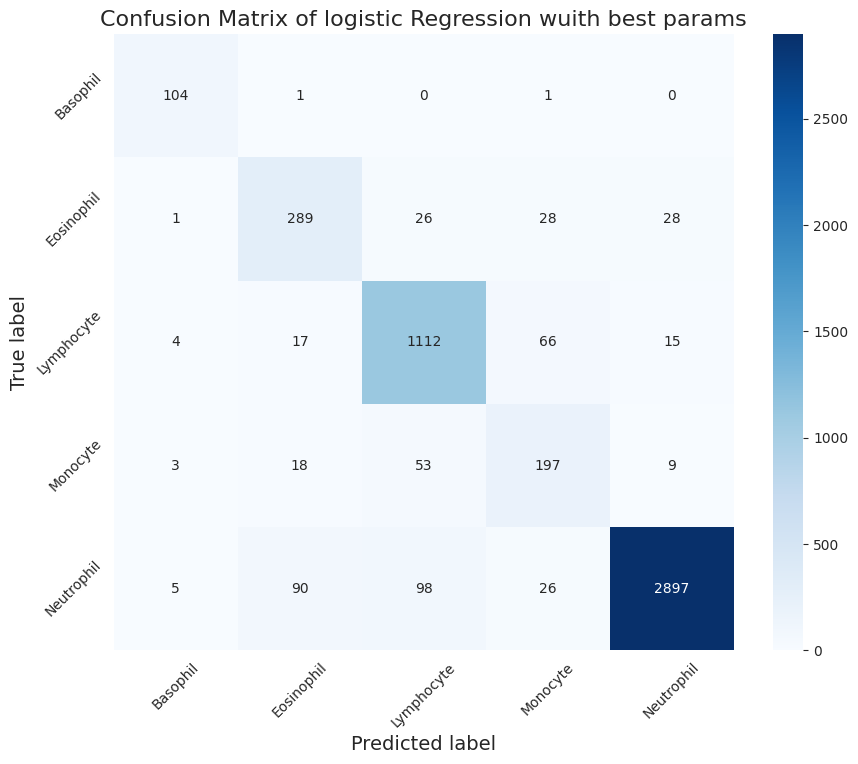

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

X_train = df.drop(['Class', 'image filename'], axis=1)
y_train = df['Class']
X_test = dft.drop(['Class', 'image filename'], axis=1)
y_test = dft['Class']


#--------------------Find best model-------------------
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"),
    param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


#---------------------Evaluate best model------------------
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

f1 = calculate_f1_score(y_test, y_pred, unique)
print("Unweighted average F1-score:", f1)
f1_weighted = calculate_weighted_f1_score(y_test, y_pred, unique)
print("Weighted average F1-score:", f1_weighted)


#--------------------PLOTS--------------------------#
def confusion_matrix(y_true, y_pred, labels):
    matrix = np.zeros((len(labels), len(labels)), dtype=int)
    label_to_index = {label: index for index, label in enumerate(labels)}
    
    for true_label, pred_label in zip(y_true, y_pred):
        true_index = label_to_index[true_label]
        pred_index = label_to_index[pred_label]
        matrix[true_index, pred_index] += 1
    
    return matrix

labels = best_model.classes_
cm = confusion_matrix(y_test, y_pred, labels)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix of logistic Regression wuith best params', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


The accuracy of 90% indicates that the model performs quite well overall with L1 regularization.

The unweighted F1-score of 0.83 shows that the model is capable of classifying the various classes relatively evenly.

The weighted average F1-score of 0.90 is higher than the unweighted F1-score, indicating that the model performs particularly well on more frequent classes like Neutrophil.

The confusion matrix shows that the model predicts most classes well. Specifically, the more frequent classes like Neutrophil and Lymphocyte are classified very well, which aligns with the observations of the weighted F1-score and overall accuracy. However, the less common classes have more misclassifications, leading to lower F1-scores for these classes.

** Conclusion **

The logistic regression model provides overall good results with high accuracy and F1-scores. It can classify the various classes relatively evenly, although it performs less well on the less frequent classes. This suggests that the model generalizes well overall, but there is room for improvement given the imbalanced class distribution.


In [9]:
# save results
results_df = add_results_to_df(results_df, 'logistic_regression', f1_weighted, f1, accuracy)
results_df.head()

,Model,F1 Score (Weighted),F1 Score (Unweighted),Accuracy
0,random_dummy,0.440693,0.202556,0.440448
1,majority_dummy,0.465213,0.151926,0.612421
2,logistic_regression,0.906449,0.833977,0.903892


### Multi-Layer Perceptron

We will implement a Multi-Layer Perceptron with sigmoid activation functions for multi-class classification.

The architecture (# layers / units per layer), regularization factor ($\alpha$), learning rate ($\eta$), and batch size should be configurable.

#### Cost Function

The following cost function $J$ should be minimized (_cross-entropy_ with regularization):

\[ 
J(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} \left( - y_k^{(i)} \log \hat{y}_k^{(i)} \right) + C 
\]

\[ 
C = \frac{\alpha}{2} \sum_{l=1}^{L} \sum_{j=1}^{u^{(l)}} \sum_{i=1}^{u^{(l-1)}} \left( w^{(l)}_{ij} \right)^2 
\]


#### Notation

- $N$: Number of data points
- $L$: Number of layers (excluding input layer)
- $K$: Number of classes
- $p$: Number of input features
- $\alpha$: Regularization factor
- $\mathbf{a}^{(l)}$: Activations in layer $l$ ($l=0$ is input layer)
- $\mathbf{z}^{(l)}$: Pre-activations / logits in layer $l$
- $\mathbf{y}^{(i)} \in \{0, 1\}$: One-hot encoded vector with dimensionality $\mathbb{R}^K$, entry 1 indicates class membership
- $\hat{y}_k^{(i)}$: Prediction for class $k$, $P(Y=k| x^{(i)})$
- $w^{(l)}_{ij}$: Weight / parameter $ij$ from layer $l$
- $W^{(l)}$: Parameters of layer $l$ with $\in \mathbb{R}^{u^{(l-1)} \times u^{(l)}}$ or with bias $\mathbb{R}^{(u^{(l-1)}+1) \times u^{(l)}}$
- $u^{(l)}$: Number of nodes (units) in layer $l$, excluding bias node
- $g()$: Activation function

#### Forward Pass

Exemplary for a data point $\mathbf{x}^{(i)}$. We assume that the bias has been added as a column of ones $x_0^{(i)}=1$.

\[
\begin{align*}
\mathbf{a}^{(0)} &= \mathbf{x}^{(i)} \\
\mathbf{z}^{(1)} &= \mathbf{a}^{(0)T}W^{(1)} \\
\mathbf{a}^{(1)} &= g(\mathbf{z}^{(1)}) \\
.. &= .. \\
\mathbf{z}^{(l)} &= \mathbf{a}^{(l-1)T}W^{(l)} \\
\mathbf{a}^{(l)} &= g(\mathbf{z}^{(l)}) \\
.. &= .. \\
\mathbf{\hat{y}}_k^{(i)} &= a_k^{(L)} \\
g(\mathbf{z}^{(l)}) &=  \frac{1}{1+e^{-z^{(l)}}} & \text{Sigmoid activation function for hidden layers } (l < L) \\
a_i^{(L)} &= \sigma(\mathbf{z}^{(L)})_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} & \text{ Softmax function for } l = L
\end{align*}
\]

#### Backpropagation

Backpropagation is the central algorithm for training neural networks to compute the partial derivatives of the loss function with respect to the parameters. The gradient of the loss function is propagated back from the output of the network using the chain rule. Use this algorithm to determine all $\frac{\partial J}{\partial \mathbf{w_{ij}^{(l)}}}$. The following relationships are helpful for the implementation:

\[
\begin{align*}
\frac{\partial a^{(l)}}{\partial z^{(l)}} &= g(z^{(l)})(1 - g(z^{(l)})) = a^{(l)} \odot (1- a^{(l)}) & \text{for } l < L \\
\frac{\partial z^{(l)}}{\partial a^{(l-1)}} &= W^{(l)} \\
\frac{\partial z^{(l)}}{\partial W^{(l)}} &= a_i^{(l-1)}
\end{align*}
\]

The gradient of the cost function with respect to the weights $W$ can be determined recursively:

\[
\begin{align*}
\frac{\partial J}{\partial \mathbf{z}^{(L)}} &= \delta^{(L)} = \mathbf{\hat{y}} - \mathbf{y} & \text{initialize backprop with this} \\
\delta^{(l)} &= \Big(\frac{\partial z^{(l+1)}}{\partial a^{(l)}} \delta^{(l+1)} \Big) \odot \frac{\partial a^{(l)}}{\partial z^{(l)}} & \text{compute backprop steps iteratively for } l < L \\
\frac{\partial J}{\partial W^{(l)}} &=  \Big(\frac{\partial z^{(l)}}{\partial W^{(l)}}\Big)^T \delta^{(l)}  & \text{these are the gradients of the weights!}
\end{align*}
\]

#### Vectorization

We can efficiently compute the forward pass and backpropagation by vectorizing the operations. We calculate the activations directly for all data points $N$. The bias vectors $\mathbf{b}$ are added directly to the activation matrices. Backpropagation can also be vectorized, computing the average gradient over all data points. Without vectorization, your implementation will be too slow. Here is the flow for forward propagation:

\[
\begin{align*}
\mathbf{X} & \in \mathbb{R}^{N \times (p + 1)} \\
\mathbf{A}^{(l)} & \in \mathbb{R}^{N \times (u^{(l)} + 1)} \\
\mathbf{Z}^{(l)} & \in \mathbb{R}^{N \times (u^{(l)})} \\
\mathbf{W}^{(l)} & \in \mathbb{R}^{(u^{(l-1)} + 1) \times u^{(l)}} \\
\mathbf{b}^{(l)} & \in \mathbb{R}^{u^{(l)} \times 1} \\
\mathbf{Z}^{(1)} &= \mathbf{X} \mathbf{W}^{(1)} \\
\mathbf{A}^{(1)} &= g( \mathbf{Z}^{(1)}) & \text{add bias node if necessary} \\
... &= ... \\
\mathbf{A}^{(L)} &= g( \mathbf{Z}^{(L)}) & \text{no bias at output} \\
\end{align*}
\]


The following diagram illustratively shows the structure of an MLP. Note the inserted bias nodes (orange), which are only connected to neurons in the next layer.

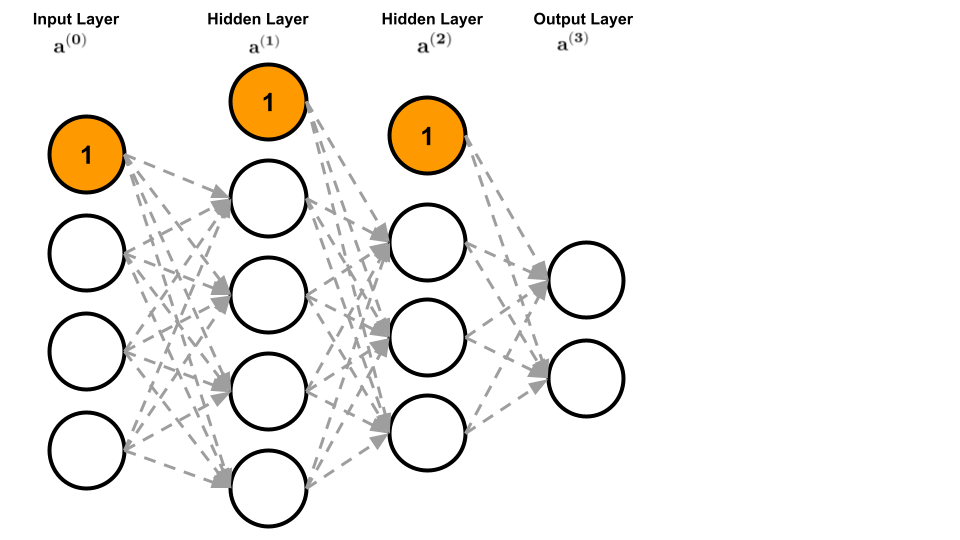

In [10]:
from IPython.display import Image
Image(filename='mlp.png') 

In [11]:
import copy
from itertools import islice
from typing import List, Tuple, Union, Iterable

from matplotlib import pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator
from mlxtend.plotting import plot_decision_regions
from matplotlib.animation import FuncAnimation
import math

class MLPClassifier(BaseEstimator):
    """ Multi-Layer Perceptron for Classification
    
        Args:
            num_nodes_per_layer: List with the number of nodes per layer
                 - including input-layer (features)
                 - no bias nodes should be included
                 - example: [10, 5, 2] -> 10 Features, 5 Nodes in 1st Hidden Layer, 2 Output Nodes
    
            lr: initial learning rate (float)
    
            alpha: L2 Regularization strength (float)
            
            batch_size: number of samples to use for one update 
                - set to None for batch gradient descent (all samples)
        
            max_num_steps: max number of steps (gradient updates)
            
            weights_init_range: Tuple of two floats. 
                - The interval on which the weights will be randomly initialized
                
            adaptive_lr_constant: Adaptive learning rate constant
                - lr_new = lr * exp(-adaptive_lr_constant * step)
                - disable with 0.0
    
            min_lr: Minimum Learning Rate, relevant when using adaptive_lr_constant > 0.0
            
            random_seed: random seed for weights initialization (int)
    """
    def __init__(
        self, 
        num_nodes_per_layer: List[int],
        lr: float=0.01,
        alpha: float=0.0,
        batch_size: Union[int, None]=None,
        max_num_steps: int=1000,
        weights_init_range: Tuple[float, float]=(-0.7, 0.7),
        adaptive_lr_constant: float=0.0,
        min_lr: float=1e-4,
        random_seed: int=123
    ):
        self.num_nodes_per_layer = num_nodes_per_layer
        self.lr = lr
        self.alpha = alpha
        self.batch_size = batch_size
        self.max_num_steps = max_num_steps
        self.weights_init_range = weights_init_range
        self.adaptive_lr_constant = adaptive_lr_constant
        self.min_lr = min_lr
        self.random_seed = random_seed
        self._initialize_weights()
        self.history = {'loss': [], 'val_loss': []}
        self.snapshots = []


    def _initialize_weights(self):
        np.random.seed(self.random_seed)
        self.weights_ = []
        for i in range(1, len(self.num_nodes_per_layer)):
            input_dim = self.num_nodes_per_layer[i-1] + 1  # +1 for the bias term
            output_dim = self.num_nodes_per_layer[i]
            W = np.random.uniform(self.weights_init_range[0], self.weights_init_range[1], (input_dim, output_dim))
            self.weights_.append(W)


    def forward(self, X: np.ndarray) -> List[np.ndarray]:
            activations = [X]
            X = np.hstack((np.ones((X.shape[0], 1)), X))  # Add bias term
        
            for index, weights in enumerate(self.weights_):
                z = np.dot(X, weights)  # Linear combination
        
                if index < len(self.weights_) - 1:
                    a = self.sigmoid(z)
                else:
                    a = self.softmax(z)
        
                X = np.hstack((np.ones((a.shape[0], 1)), a))  # Add bias term
                activations.append(a)
        
            return activations
    
    
    def backward(self, activations: List[np.ndarray], delta_upstream: np.ndarray) -> List[np.ndarray]:
        num_samples = delta_upstream.shape[0]
        gradients = [np.zeros_like(w) for w in self.weights_]
    
        delta = delta_upstream
        for index in reversed(range(len(self.weights_))):
            layer_activation = activations[index]
            activation_with_bias = np.hstack((np.ones((layer_activation.shape[0], 1)), layer_activation))
            gradients[index] = np.dot(activation_with_bias.T, delta) / num_samples
    
            if index > 0:
                weights_no_bias = self.weights_[index][1:]
                d_sigmoid = layer_activation * (1 - layer_activation)
                delta = np.dot(delta, weights_no_bias.T) * d_sigmoid
    
        if self.alpha > 0:
            for i in range(len(gradients)):
                gradients[i] += self.alpha * self.weights_[i]
    
        return gradients

    def fit(self, X: np.ndarray, y: np.ndarray,
            X_val: Union[np.ndarray, None]=None, y_val: Union[np.ndarray, None]=None,
            validate_after_every_num_steps: int=20) -> None:
        batch_gen = self.generate_batches(X, y, self.batch_size)
        if self.batch_size is None:
            n_batches = 1
        else:
            n_batches = math.ceil(X.shape[0] / self.batch_size)

        for step in range(self.max_num_steps):
            self.partial_fit(batch_gen, n_batches, step, validate_after_every_num_steps, X_val, y_val)

    def calculate_cost(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        m = y_pred.shape[0]
        crossEntropyLoss = -np.sum(y_true * np.log(y_pred)) / m        
        regularization = 0
        for Weight in self.weights_:
            regularization += np.sum(np.square(Weight))
        regCost = 0.5 * self.alpha * regularization
        return crossEntropyLoss + regCost
    
    def calculate_gradient_of_cost_function(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        gradient = y_pred - y_true
        return gradient

    def softmax(self, x: np.ndarray) -> np.ndarray:
        x = np.clip(x, -100, 100)
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)

    def sigmoid(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-np.clip(x, -100, 100)))

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        activations = self.forward(X)
        probabilities = activations[-1]
        return probabilities

    def predict(self, X: np.ndarray) -> np.ndarray:
        probabilities = self.predict_proba(X)
        predictions = np.argmax(probabilities, axis=1)
        predictions = predictions.reshape(-1, 1)
        return predictions

    def score(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        predictions = self.predict(X)
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        correct_predictions = np.sum(predictions == y)
        accuracy = correct_predictions / len(y)
        return accuracy

    def generate_batches(
                self, X: np.ndarray, y: np.ndarray,
                batch_size: Union[int, None],
                shuffle: bool = True) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
            """ Generate batches of data [BATCH_SIZE, NUM_FEATURES]"""
    
            # Batch Gradient Descent
            if not batch_size:
                batch_size = X.shape[0]
                while True:
                    yield X, y
    
            # Flexible Batch-Size that works with batch_size != None
            while True:
                # randomly shuffle input data
                shuffled_indices = np.arange(X.shape[0])
                if shuffle:
                    np.random.shuffle(shuffled_indices)
    
                # iterate over batches
                iter_indices = np.arange(X.shape[0])
                slices = islice(iter_indices, 0, None, batch_size)
    
                # select batches
                for start_index in slices:
                    indices_to_select = shuffled_indices[start_index: start_index + batch_size]
                    yield X[indices_to_select, :], y[indices_to_select, :]
                
                
    def grad_check(
            self, X: np.ndarray, y: np.ndarray,
            epsilon: float = 0.0001,
            decimal: int = 3,
            verbose: bool = False) -> None:
        """Compare the gradient with finite differences around current point in parameter space
            Args:
                X, y: Data
                epsilon: step to take around current parameters
                decimal: verify equality if approximaton is within +- 1e-<decimal>
        """
        # calculate gradient
        activations = self.forward(X)
        y_hat = activations[-1]
        delta_upstream = self.calculate_gradient_of_cost_function(y, y_hat)
        gradients = self.backward(activations, delta_upstream)

        # approximate gradient
        gradients_approx = copy.deepcopy(gradients)
        original_layers = copy.deepcopy(self.weights_)

        # Iterate over each parameter of the network
        for i, weights in enumerate(self.weights_):
            for j, _ in enumerate(weights.flat):
                # generate copy of original parameters for modification
                modified_layers = copy.deepcopy(original_layers)

                # assign modified layers for use in other methods
                self.weights_ = modified_layers

                # J(theta + epsilon)
                modified_layers[i].flat[j] += epsilon
                y_hat = self.predict_proba(X)
                cost_plus_epsilon = self.calculate_cost(y, y_hat)

                # J(theta - epsilon)
                modified_layers[i].flat[j] -= 2 * epsilon
                y_hat = self.predict_proba(X)
                cost_minus_epsilon = self.calculate_cost(y, y_hat)

                # Approx gradient with:
                # (J(theta + epsilon) - J(theta - epsilon)) / (2 * epsilon)
                grad_approx = (
                        (cost_plus_epsilon - cost_minus_epsilon) /
                        (2 * epsilon))

                gradients_approx[i].flat[j] = grad_approx

        # reset layers attribute
        self.weights_ = copy.deepcopy(original_layers)

        # normalize gradients
        gradients_approx = [x / np.linalg.norm(x) for x in gradients_approx]
        gradients = [x / np.linalg.norm(x) for x in gradients]

        if verbose:
            print('approx : ', gradients_approx)
            print('calc : ', gradients)

        for approx, calculated in zip(gradients_approx, gradients):
            np.testing.assert_array_almost_equal(approx, calculated, decimal=decimal)
        print(f"Gradients within +- 1e-{decimal} of approximated gradient!")
        
        
    def partial_fit(self, batch_gen, n_batches, step, validate_after_every_num_steps, X_val, y_val):
        total_cost = 0
        for _ in range(n_batches):
            X_batch, y_batch = next(batch_gen)
            # Forward pass
            activations = self.forward(X_batch)
            y_hat = activations[-1]
            # Calculate gradients
            delta_upstream = self.calculate_gradient_of_cost_function(y_batch, y_hat)
            gradients = self.backward(activations, delta_upstream)
            # Update weights with gradient descent
            lr = max(self.min_lr, self.lr * np.exp(-self.adaptive_lr_constant * step))
            for i in range(len(self.weights_)):
                self.weights_[i] -= lr * gradients[i]

            total_cost += self.calculate_cost(y_batch, y_hat)

        average_cost = total_cost / n_batches
        self.history['loss'].append(average_cost)
    
        self.check_validate(step, validate_after_every_num_steps, X_val, y_val)

    def check_validate(self, step, validate_after_every_num_steps, X_val, y_val):
        if X_val is not None and y_val is not None and step % validate_after_every_num_steps == 0:
            val_activations = self.forward(X_val)
            val_predictions = val_activations[-1]
            val_cost = self.calculate_cost(y_val, val_predictions)
            self.history['val_loss'].append(val_cost)
            return val_cost

    def create_animation(self, X: np.ndarray, y: np.ndarray, filename: str = 'decision_regions.gif'):
        y_labels = np.argmax(y, axis=1)
        fig, ax = plt.subplots()
        def update_plot(frame_index, model, X, y, ax):
            ax.clear()
            model.weights_ = model.snapshots[frame_index]
            plot_decision_regions(X, y, clf=model, legend=2, ax=ax)
            ax.set_title(f'Decision Regions at Step {frame_index * 1000}')
        anim = FuncAnimation(fig, update_plot, frames=len(self.snapshots), fargs=(self, X, y_labels, ax), repeat=False)
        anim.save(filename, writer='imagemagick', fps=5)
        plt.show()
        
    def fit_and_save_decision_regions(self, X: np.ndarray, y: np.ndarray,
        X_val: Union[np.ndarray, None]=None, y_val: Union[np.ndarray, None]=None,
        validate_after_every_num_steps: int=20) -> None:
        batch_gen = self.generate_batches(X, y, self.batch_size)
        
        if self.batch_size is None:
            n_batches = 1
        else:
            n_batches = math.ceil(X.shape[0] / self.batch_size)

        for step in range(self.max_num_steps):
            self.partial_fit(batch_gen, n_batches, step, validate_after_every_num_steps, X_val, y_val)
        
            if step % 1000 == 0 or step == self.max_num_steps - 1:
                    self.snapshots.append(copy.deepcopy(self.weights_))


Lets see if the implementation works using dev_data.csv, a smaller, much simple data set which is easier to compute.  

We are generating a MLP with 2 hiffen layers with 20 units/Nodes each plus Bias Unit

Gradients within +- 1e-3 of approximated gradient!
Train Accuracy: 1.00
Validation Accuracy: 0.97


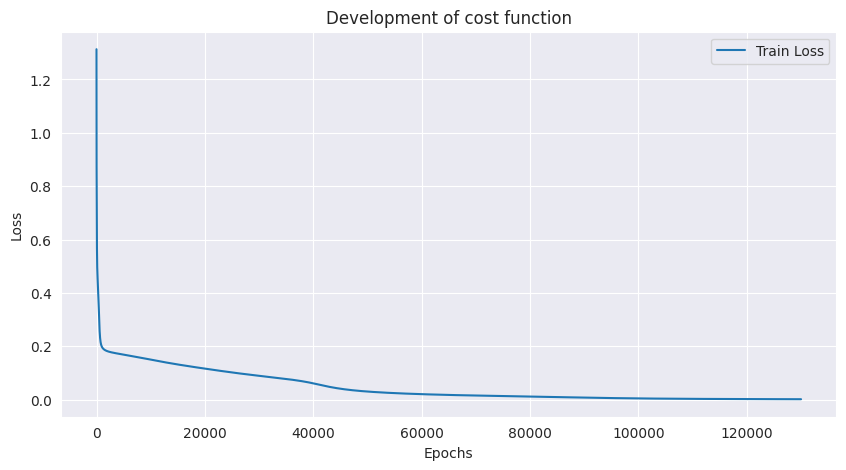

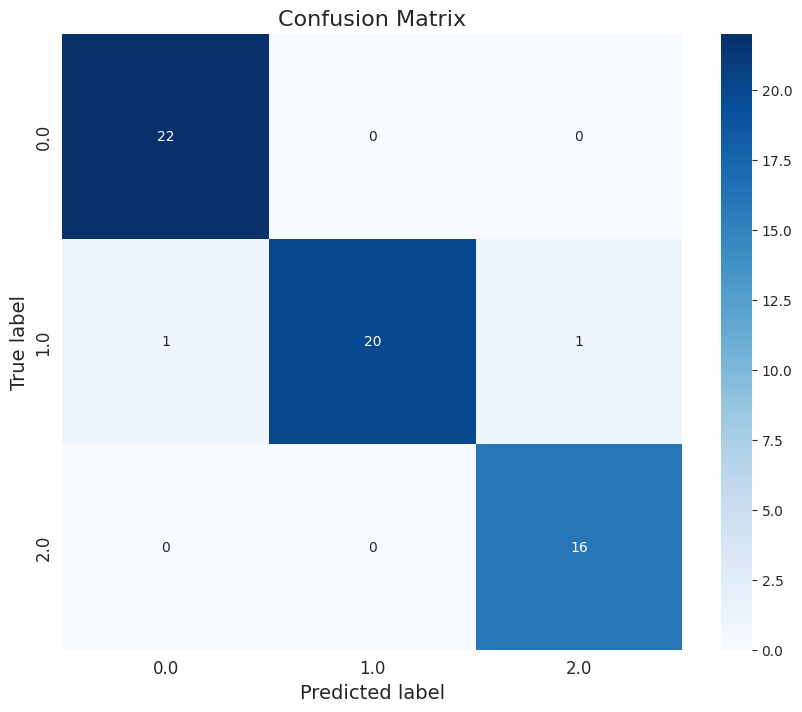

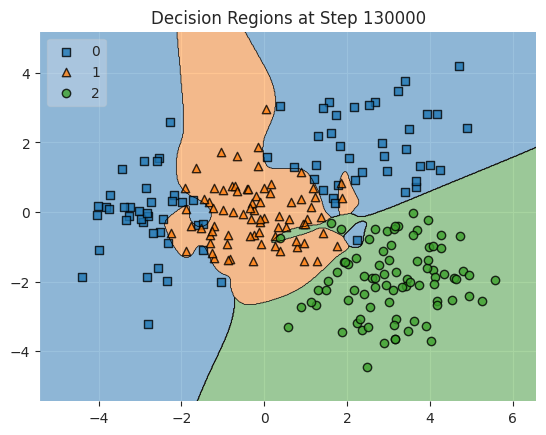

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

data = pd.read_csv('data/dev_data.csv')
X = data[['x1', 'x2']].values
y = data['y'].values

# ----------------------One-Hot-Encoding--------------------------
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# ---------------------Split in Training and validate data-------------------
X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

#---------------Init model + gradcheck + fit-----------------
mlp = MLPClassifier(
    num_nodes_per_layer=[2, 20, 20, 3],
    max_num_steps=130000,
    lr=0.3,
)
mlp.grad_check(X, y_onehot, verbose=False)
mlp.fit_and_save_decision_regions(X_train, y_train, X_val, y_val)

#----------------evaluate accuracy-------------------------
train_accuracy = mlp.score(X_train, np.argmax(y_train, axis=1))
val_accuracy = mlp.score(X_val, np.argmax(y_val, axis=1))
print(f'Train Accuracy: {train_accuracy:.2f}')
print(f'Validation Accuracy: {val_accuracy:.2f}')

# ---------------------------plot Cost function-----------------------------
plt.figure(figsize=(10, 5))
plt.plot(mlp.history['loss'], label='Train Loss')
plt.title('Development of cost function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#--------------------------------Predict data--------------------------------
y_train_pred = mlp.predict(X_train)
y_val_pred = mlp.predict(X_val)

#---------------Confusion matrix-----------------------
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_val_labels, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Animation of decision regions, will take long time
mlp.create_animation(X_train, y_train.astype(int), filename='decision_regions.gif')


### Discussion of Results

The model achieves a training accuracy of 100% and a validation accuracy of 97%. This indicates that the model has perfectly learned the training data and generalizes well. However, it could also mean that the model is slightly overfitting. A look at the decision regions suggests that this might be the case.

The cost function's trajectory shows that the loss, or cost, decreases over time and approaches zero. This means that the model has trained well and converged.

The confusion matrix shows that almost all predictions are correct, and the model is generally good at predicting classes accurately. There are only 2 misclassifications, which might be justified in light of the decision regions, as the regions of the classes partially overlap. This could potentially be improved with more data/features.

### Conclusion

Overall, the model shows very strong performance with high accuracy for both test and training data, demonstrating the functionality of my MLP implementation.

To reduce/avoid potential overfitting, stronger regularization could be applied or the number of epochs could be reduced.


### MLP Implementation for Blood celltypes

Removing Outliers: 188
Best parameters: ([25, 25], 5, 1000)
Best F1-Score: 0.9425
Accuracy: 0.9438
F1 Score: 0.9425
Unweighted Mean F1-Score: 0.8899


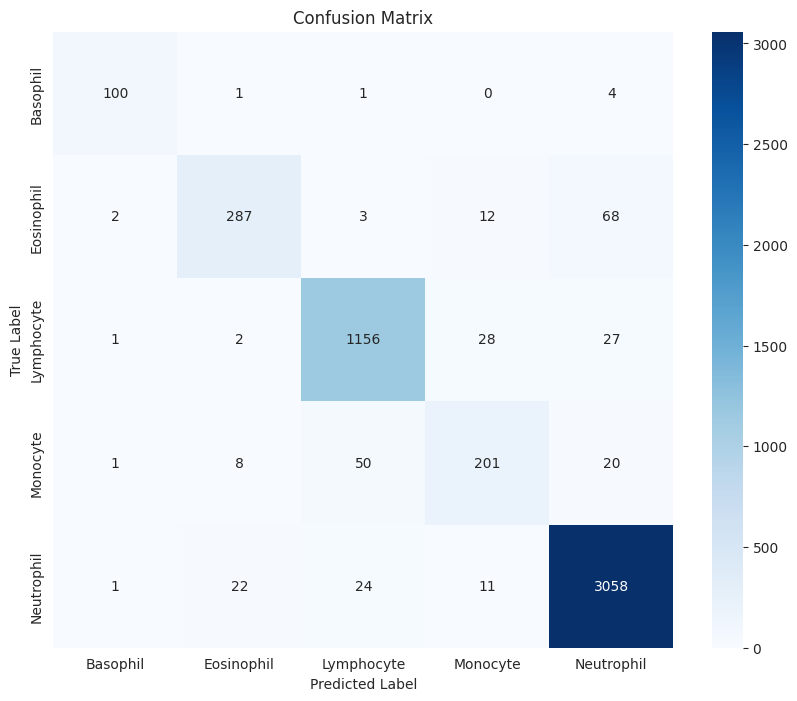

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy import stats


df = pd.read_csv('data/bloodcells_train.csv', delimiter=';')
dft = pd.read_csv('data/bloodcells_test.csv', delimiter=';')

X_train = df.drop(['Class', 'image filename'], axis=1)
y_train = df['Class']

X_test = dft.drop(['Class', 'image filename'], axis=1)
y_test = dft['Class']

#-------------------Scale data, clean, etc. ----------------------------
#Scale 
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def remove_outliers_per_class(X, y, threshold=3):
    unique_classes = np.unique(y)
    indices_to_keep = []
    for cls in unique_classes:
        class_indices = np.where(y == cls)[0]
        class_X = X[class_indices]
        z_scores = np.abs(stats.zscore(class_X))
        class_outliers = np.where(z_scores > threshold)
        keep_indices = set(class_indices) - set(class_outliers[0])
        indices_to_keep.extend(keep_indices)
    return X[indices_to_keep], y[indices_to_keep]

X_train_no_outliers, y_train_no_outliers = remove_outliers_per_class(X_train, y_train, threshold=3)
print(f"Removing Outliers: {len(X_train) - len(X_train_no_outliers)}")
X_train = X_train_no_outliers
y_train = y_train_no_outliers

# One hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_onehot = encoder.fit_transform(y_test.values.reshape(-1, 1))



#---------------------------Manuelle Grid-Suche-------------------------
param_grid = {
    'hidden_layer_sizes': [
        [50, 50, 50], [100, 100], [25,25], [1]
    ],
    'learning_rate_init': [0,0.1,1,5,10],
}

best_f1_score = -np.inf
best_params = None
best_model = None

for hidden_layer_sizes, learning_rate_init in product(param_grid['hidden_layer_sizes'], param_grid['learning_rate_init']):
    mlp = MLPClassifier(
        num_nodes_per_layer=[X_train.shape[1]] + hidden_layer_sizes + [y_train_onehot.shape[1]],
        lr=learning_rate_init,
        max_num_steps=1000 # 1000 is a tradeoff where the runtime is acceptable, more steps would probably increase model performance
    )
    
    mlp.fit(X_train, y_train_onehot)
    y_pred = mlp.predict(X_test)
    y_pred_labels = y_pred.ravel()
    y_test_labels = np.argmax(y_test_onehot, axis=1)
    
    f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_params = (hidden_layer_sizes, learning_rate_init, 1000)
        best_model = mlp    
        

print(f"Best parameters: {best_params}")
print(f"Best F1-Score: {best_f1_score:.4f}")

    

#------------------------------Predictions and evaluation of model-------------------------------
y_pred = best_model.predict(X_test)
y_pred_labels = y_pred.ravel()
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {best_f1_score:.4f}")

unweighted_f1 = f1_score(y_test_labels, y_pred_labels, average='macro')
print(f"Unweighted Mean F1-Score: {unweighted_f1:.4f}")


#------------------------PLOTS-----------------------------

conf_matrix = np.zeros((len(encoder.categories_[0]), len(encoder.categories_[0])), dtype=int)
for true_label, pred_label in zip(y_test_labels, y_pred_labels):
    conf_matrix[true_label, pred_label] += 1

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



### Approach

**Preprocessing:**

- **Feature Scaling:** The data was scaled using RobustScaler to handle outliers and bring the data to similar value ranges.
    
- **Outlier Removal:** A function was implemented and applied to remove outliers in the data per class. This is done by calculating Z-scores and removing values that exceed a threshold.
    
- **One-Hot Encoding:** The target variables were one-hot encoded to prepare them for modeling.

**Model Training:**

- **Hyperparameter Optimization:** A manual grid search was conducted to find the best hyperparameters for the model. Various combinations of the number of layers and learning rates were tested. It is important to mention that the number of steps was limited to 1000 to minimize runtime. A higher number of steps would likely yield a better model.
    
- **Model Evaluation:** The model with the best hyperparameters was evaluated on the test data. The weighted F1-score and accuracy were calculated to assess the model's performance.

**Model Evaluation and Results:**

- **Model Performance:** The model shows very high performance with an accuracy of 94.4% (rounded) and a weighted F1-score of 94.4% (rounded). This indicates that the model can predict blood cell types well and is capable of applying this to new data.
    
- **Unweighted F1-Score:** The unweighted F1-score of 0.89% (rounded) shows that the model can also classify less frequent classes well. This is particularly important in the medical context where all classes might be equally important.
    
- **Confusion Matrix:** The matrix shows that most classes are well classified. Some misclassifications are present, particularly in classes like Monocyte and Lymphocyte. These errors might be due to similar features.

### Conclusion

The model shows very strong performance in classifying blood cells.

While preprocessing did improve the model's results, it had a limited impact on model performance, which could be due to the high quality of the data.

To further improve the model, an analysis of misclassifications and further optimization procedures could be conducted (requiring more time and computational power).


In [14]:
# Save model for later
results_df = add_results_to_df(results_df, 'my_mlp', best_f1_score, unweighted_f1, accuracy)
results_df.head()

,Model,F1 Score (Weighted),F1 Score (Unweighted),Accuracy
0,random_dummy,0.440693,0.202556,0.440448
1,majority_dummy,0.465213,0.151926,0.612421
2,logistic_regression,0.906449,0.833977,0.903892
3,my_mlp,0.942518,0.889861,0.943789


###  Batchsizes
Fitting the MLP with different Batch sizes 265, 128, 64, 32, 16, 8, 4, 2, 1 to find the optimal size

batchsize: 265, Training_time: 4.6726930141448975 s
batchsize: 128, Training_time: 2.5354855060577393 s
batchsize: 64, Training_time: 3.4356093406677246 s
batchsize: 32, Training_time: 6.901730298995972 s
batchsize: 16, Training_time: 7.599387884140015 s
batchsize: 8, Training_time: 12.05214524269104 s
batchsize: 4, Training_time: 20.220229148864746 s
batchsize: 2, Training_time: 36.63622236251831 s
batchsize: 1, Training_time: 70.77007603645325 s


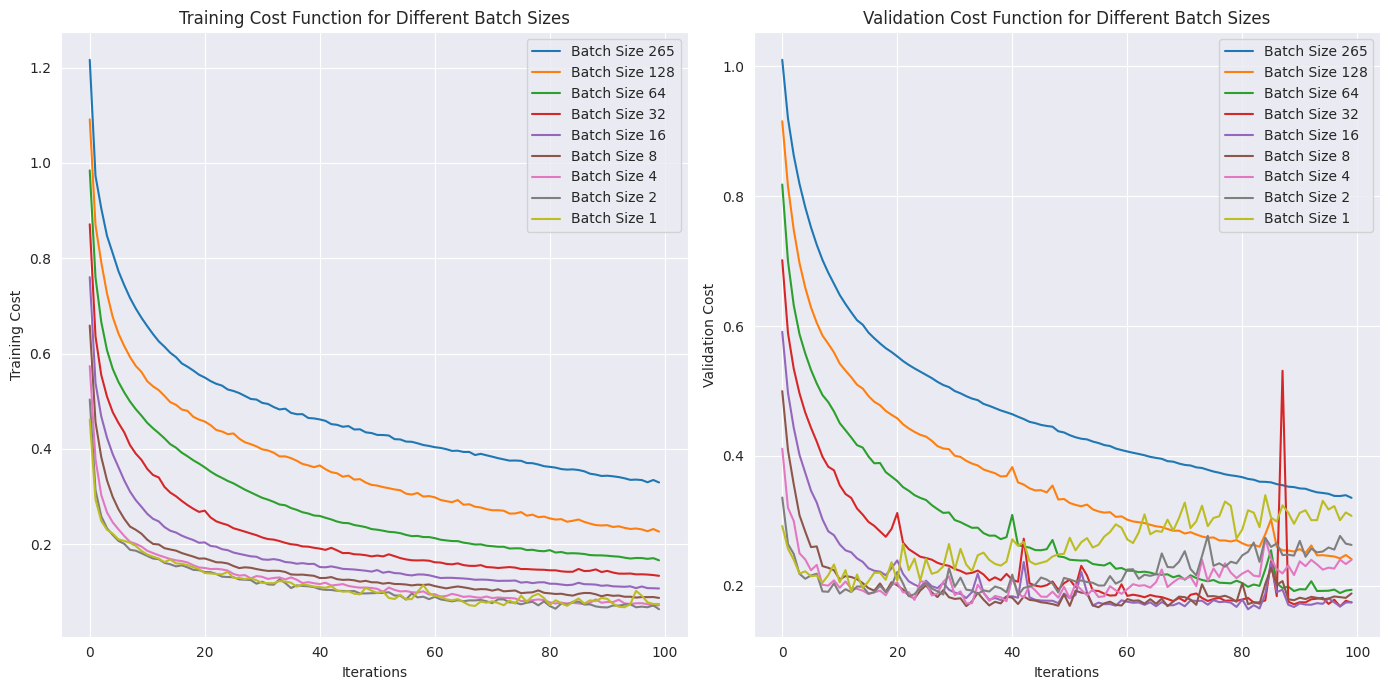

In [15]:
import time
import matplotlib.pyplot as plt

batch_sizes = [265, 128, 64, 32, 16, 8, 4, 2, 1]

#------------------Make models with different batch sizes-------------------
training_histories = {}
validation_histories = {}
training_times = {}

for batch_size in batch_sizes:
    mlp = MLPClassifier(
            num_nodes_per_layer=[X_train.shape[1], 25, 25, y_train_onehot.shape[1]],
            lr=0.1,
            max_num_steps=100,
            batch_size=batch_size
    )    
    start_time = time.time()
    mlp.fit(X_train, y_train_onehot, X_test, y_test_onehot, validate_after_every_num_steps=1)
    training_time = time.time() - start_time
    
    training_histories[batch_size] = mlp.history['loss']
    validation_histories[batch_size] = mlp.history['val_loss']
    print(f'batchsize: {batch_size}, Training_time: {training_time} s')

#----------------------plot costs for different models------------------------
def plot_all_costs(training_histories, validation_histories):
    plt.figure(figsize=(14, 7))

    # Plot training costs
    plt.subplot(1, 2, 1)
    for batch_size, training_history in training_histories.items():
        plt.plot(training_history, label=f'Batch Size {batch_size}')
    plt.xlabel('Iterations')
    plt.ylabel('Training Cost')
    plt.title('Training Cost Function for Different Batch Sizes')
    plt.legend()
    plt.grid(True)

    # Plot validation costs
    plt.subplot(1, 2, 2)
    for batch_size, validation_history in validation_histories.items():
        plt.plot(validation_history, label=f'Batch Size {batch_size}')
    plt.xlabel('Iterations')
    plt.ylabel('Validation Cost')
    plt.title('Validation Cost Function for Different Batch Sizes')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot all costs
plot_all_costs(training_histories, validation_histories)


### Observations and Analysis of Batch Sizes

**Training & Validation Costs**

Smaller batch sizes (4, 2, 1) show faster convergence and lower training costs compared to larger batch sizes (128, 265). These larger batch sizes converge more slowly and require more iterations to reach similar costs as the smaller ones.

Smaller batch sizes (1, 2, 4, 8) show significant fluctuations and spikes in validation costs, possibly due to stochastic noise in gradient calculation. Larger batch sizes (64, 128, 265) converge more slowly but show a more consistent decrease and stable, smoother validation curves with fewer fluctuations. While smaller batch sizes quickly achieve low validation costs, the fluctuations make it challenging to assess actual convergence.

**Execution Times**

Smaller batch sizes tend to require more time per epoch, as the gradient is calculated for each smaller batch. However, the total training time can be shorter due to faster convergence.

Larger batch sizes lead to faster computation per iteration but may require more iterations to converge (confirmed by the cost plot).

### Criteria for Selecting Batch Size

**Convergence Speed:** Smaller batch sizes tend to converge faster and achieve lower costs.

**Training/Computation Time:** Depending on the dataset, choosing a smaller batch size may extend total training time as it converges faster but requires more iterations and, therefore, more computation time. A balance between batch size and training time must be found.

**Computational Resources:** Larger batch sizes are more efficient in terms of resource utilization, requiring fewer memory accesses and less communication between memory and processor. Depending on the available hardware, this can be advantageous and can also affect computation time.

**Stability of Gradient Calculation:** Smaller batch sizes can lead to more gradient noise (see plots), making optimization more difficult.

### Conclusion

Smaller batch sizes offer advantages in terms of rapid convergence and generalization but can take significantly longer and potentially cause noise in the gradient. Larger batch sizes are more efficient in terms of runtime and resources but may require more iterations to converge.

The optimal batch size depends on the specific requirements of the dataset. For the blood cell classification model, a higher batch size will suffice to minimize costs and maximize accuracy without consuming too much computation time, as the model already requires substantial computation time. Generally, a balance should be found between the pros and cons of different batch sizes.

| Batch Size            | Advantages                                                                                            | Disadvantages                                                                                         |
|-----------------------|--------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------|
| **Smaller Batch Sizes** | - Faster convergence<br>- Faster learning                                                               | - More fluctuations and noise in validation costs<br>- Can lead to unstable learning curves              |
| **Larger Batch Sizes**  | - Smoother and more stable learning curves<br>- More efficient use of computational resources            | - Slower convergence<br>- Requires more iterations to converge                                         |


### Comparing Classification Algorithms

Best Random Forest F1 Score (weighted): 0.9300775487995463
Best Random Forest F1 Score (macro): 0.8707022804511231
Best Random Forest Accuracy: 0.9318003144654088


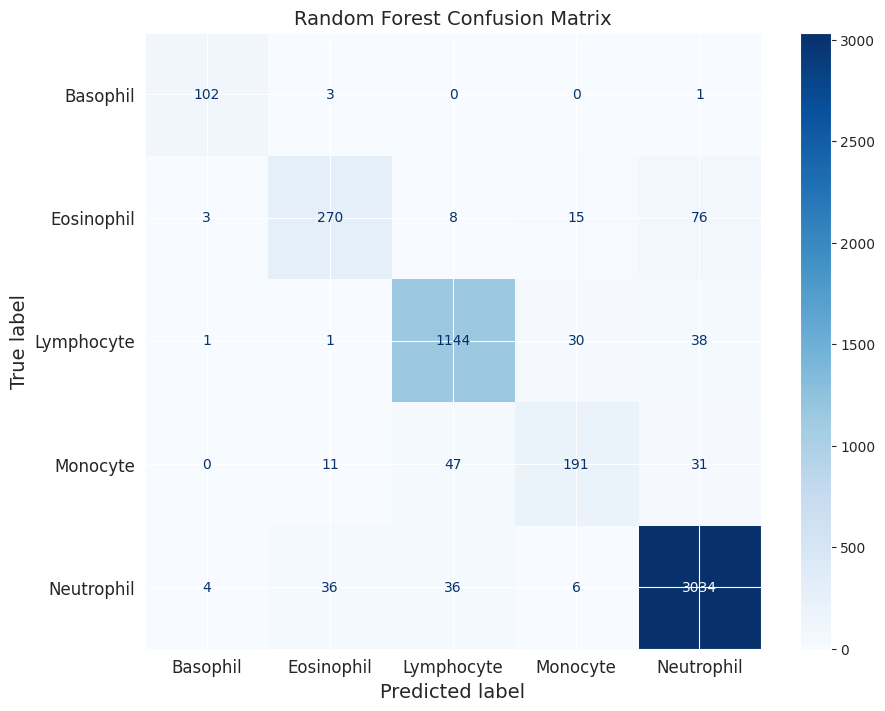

Best SVM F1 Score (weighted): 0.9370608089669867
Best SVM F1 Score (macro): 0.8751230815790351
Best SVM Accuracy: 0.9386792452830188


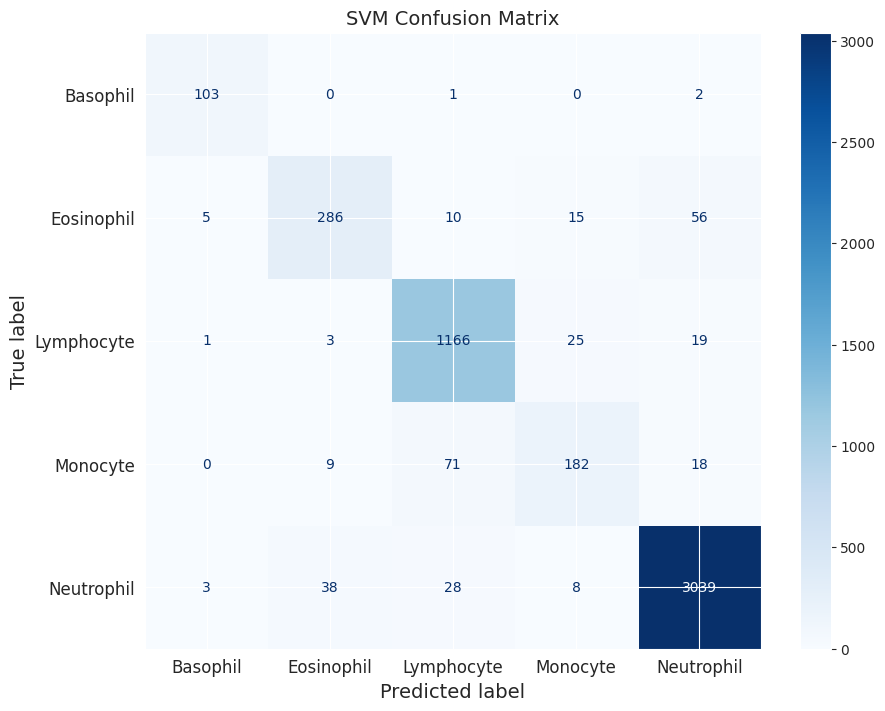

Best MLP from sklearn F1 Score (weighted): 0.9367151157841194
Best MLP from sklearn F1 Score (macro): 0.8897058349362641
Best MLP from sklearn Accuracy: 0.9371069182389937


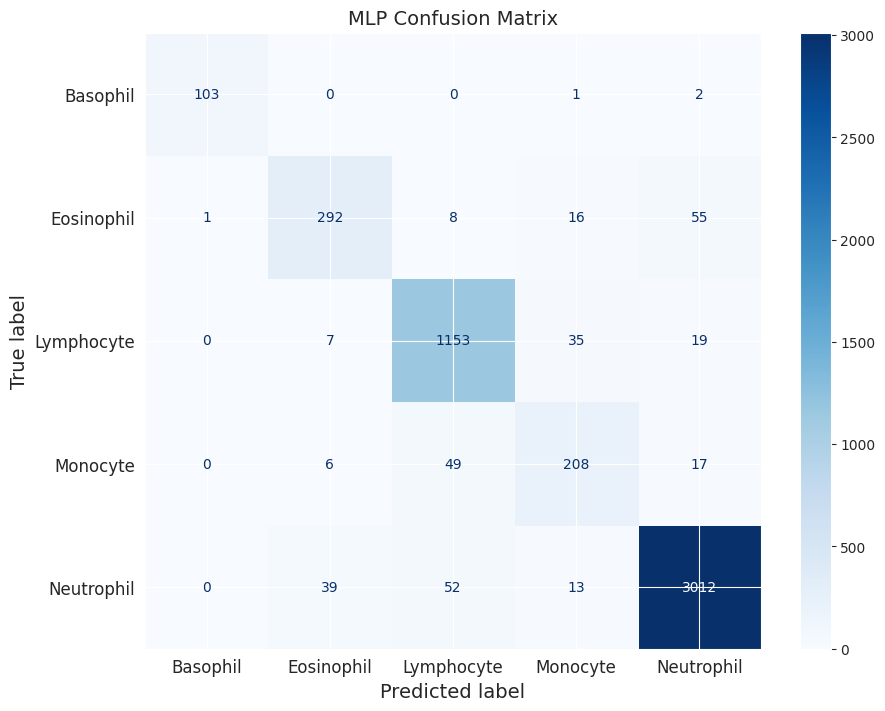

In [16]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, title, labels, fontsize=14):
    fig, ax = plt.subplots(figsize=(10, 8))  # Increase figure size for better readability
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', ax=ax)
    plt.title(title, fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.ylabel('True label', fontsize=fontsize)
    plt.xticks(fontsize=fontsize - 2)
    plt.yticks(fontsize=fontsize - 2)
    plt.show()

# ------------------------------ Random Forest Classifier --------------------
rf_clf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(rf_clf, param_grid_rf, cv=3, scoring='f1_weighted', n_jobs=2)
grid_search_rf.fit(X_train, y_train)

best_rf_clf = grid_search_rf.best_estimator_
y_pred_rf = best_rf_clf.predict(X_test)
f1_rf_weighted = f1_score(y_test, y_pred_rf, average='weighted')
f1_rf_macro = f1_score(y_test, y_pred_rf, average='macro')
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Best Random Forest F1 Score (weighted): {f1_rf_weighted}")
print(f"Best Random Forest F1 Score (macro): {f1_rf_macro}")
print(F"Best Random Forest Accuracy: {accuracy_rf}")

# Plots
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, "Random Forest Confusion Matrix", encoder.categories_[0])


# ----------------------------- Support Vector Machine ------------------------
svm_clf = SVC(random_state=42)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'rbf']
}

grid_search_svm = GridSearchCV(svm_clf, param_grid_svm, cv=3, scoring='f1_weighted', n_jobs=2)
grid_search_svm.fit(X_train, y_train)

best_svm_clf = grid_search_svm.best_estimator_
y_pred_svm = best_svm_clf.predict(X_test)
f1_svm_weighted = f1_score(y_test, y_pred_svm, average='weighted')
f1_svm_macro = f1_score(y_test, y_pred_svm, average='macro')
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"Best SVM F1 Score (weighted): {f1_svm_weighted}")
print(f"Best SVM F1 Score (macro): {f1_svm_macro}")
print(F"Best SVM Accuracy: {accuracy_svm}")

# Plots
cm_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cm_svm, "SVM Confusion Matrix", encoder.categories_[0])


# ----------------------MLP Classifier from Sklearn---------------------------- 
mlp_clf = MLPClassifier(max_iter=1000, random_state=42)  # Reduce max_iter for faster training
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100,), (25, 25)],
    'learning_rate_init': [0.01, 0.1],
    'alpha': [0.0001, 0.001]
}

grid_search_mlp = GridSearchCV(mlp_clf, param_grid_mlp, cv=3, scoring='f1_weighted', n_jobs=2)
grid_search_mlp.fit(X_train, y_train)

best_mlp_clf = grid_search_mlp.best_estimator_
y_pred_mlpskl = best_mlp_clf.predict(X_test)
f1_mlp_skl_weighted = f1_score(y_test, y_pred_mlpskl, average='weighted')
f1_mlp_skl_macro = f1_score(y_test, y_pred_mlpskl, average='macro')
accuracy_mlp_skl = accuracy_score(y_test, y_pred_mlpskl)

print(f"Best MLP from sklearn F1 Score (weighted): {f1_mlp_skl_weighted}")
print(f"Best MLP from sklearn F1 Score (macro): {f1_mlp_skl_macro}")
print(F"Best MLP from sklearn Accuracy: {accuracy_mlp_skl}")

# Plots
cm_mlp = confusion_matrix(y_test, y_pred_mlpskl)
plot_confusion_matrix(cm_mlp, "MLP Confusion Matrix", encoder.categories_[0])


### Discussion of Results

Confusion matrices were created for each model, and the results can be interpreted as follows:

**Random Forest Classifier**
The Random Forest classifier is an ensemble method that constructs multiple decision trees during training and outputs the mode of the classes for classification.

**Support Vector Machine (SVM)**
SVMs are supervised learning models used for classification that find the hyperplane that best separates the classes.

**Multi-Layer Perceptron (MLP) Classifier**
MLP is a type of feedforward artificial neural network model that maps input datasets to a set of appropriate outputs. It relies on backpropagation for training.

**Comparison with My MLP Classifier Model:**

- **Random Forest**: This model achieved a weighted F1-score of 0.9301, which is slightly lower than that of the custom MLP model (0.9436), and an accuracy of 0.9318. It shows robust performance but is not as high as my own or sklearn's MLP.
- **SVM**: The SVM model performed exceptionally well, with a weighted F1-score of 0.9444 and an accuracy of 0.9446, which brings it very close to my MLP model and slightly surpasses it in weighted F1-score.
- **MLP from sklearn**: The sklearn MLP achieved a weighted F1-score of 0.9333 and an accuracy of 0.9446, making it competitive with my MLP model, although my model is slightly superior in unweighted F1-score.

### Conclusion

It must be noted that my custom MLP model could theoretically be further optimized and more powerful with more iterations, which was not feasible here due to high computational requirements and duration.

**Performance**: The SVM model slightly outperformed both the Random Forest and the sklearn MLP models in terms of weighted F1-score and accuracy. However, the custom MLP model showed very competitive results and could be preferred if model interpretability and customization are crucial.

**Model Selection**: Based on the results, the SVM model is preferred due to its slightly higher F1-scores and accuracy, indicating robust classification performance across multiple classes. However, the custom MLP model also shows very competitive results and could be preferred in certain applications.


In [19]:
results_df = add_results_to_df(results_df, "random_forest", f1_rf_weighted, f1_rf_macro, accuracy_rf)
results_df = add_results_to_df(results_df, "svm", f1_svm_weighted, f1_svm_macro, accuracy_svm)
results_df = add_results_to_df(results_df, "mlp_from_sklearn", f1_mlp_skl_weighted, f1_mlp_skl_macro, accuracy_mlp_skl)
print(results_df)

                 Model  F1 Score (Weighted)  F1 Score (Unweighted)  Accuracy
0         random_dummy             0.440693               0.202556  0.440448
1       majority_dummy             0.465213               0.151926  0.612421
2  logistic_regression             0.906449               0.833977  0.903892
3               my_mlp             0.942518               0.889861  0.943789
4        random_forest             0.930078               0.870702  0.931800
5                  svm             0.937061               0.875123  0.938679
6     mlp_from_sklearn             0.936715               0.889706  0.937107


### Comparison of Results


                 Model  F1 Score (Weighted)  F1 Score (Unweighted)  Accuracy
0         random_dummy             0.440693               0.202556  0.440448
1       majority_dummy             0.465213               0.151926  0.612421
2  logistic_regression             0.906449               0.833977  0.903892
3               my_mlp             0.942518               0.889861  0.943789
4        random_forest             0.930078               0.870702  0.931800
5                  svm             0.937061               0.875123  0.938679
6     mlp_from_sklearn             0.936715               0.889706  0.937107


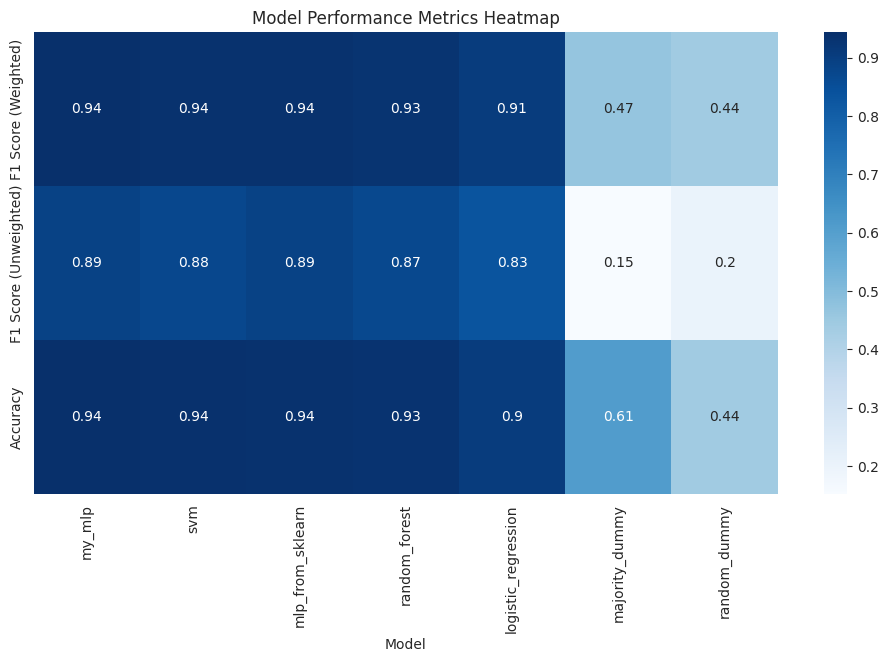

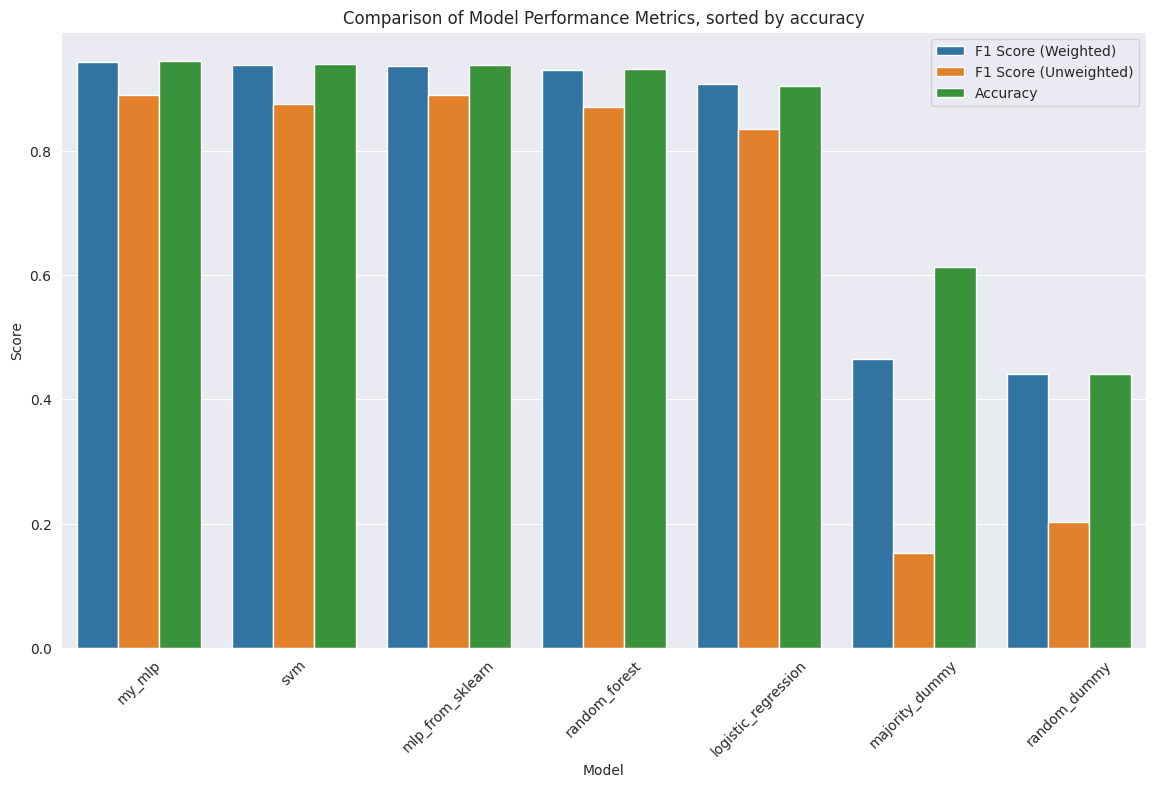

In [18]:
#Table
print(results_df)

#-----------Sort resulted models by accuracy---------------------
sorted_results_df = results_df.sort_values(by='Accuracy', ascending=False)


#--------------------------HeatMap--------------------------------
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_results_df.set_index('Model').T, annot=True, cmap='Blues')
plt.title('Model Performance Metrics Heatmap')
plt.show()

#------------------Group bar plot---------------------------------------
metrics_df = sorted_results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df)
plt.title('Comparison of Model Performance Metrics, sorted by accuracy')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

### Discussion of Results

The "Model Performance Heatmap" shows the performance metrics of various models for blood cell classification. The metrics include the weighted F1-score, unweighted F1-score, and accuracy.

The "Comparison of Model Performance Metrics" graph displays the metrics of the models in a grouped bar chart sorted by accuracy.

Based on the graphs, the following conclusions can be drawn:

**Dummy Models:**

The dummy models serve as baselines and, as expected, show poor performance. They are useful to put the performance of other models into context. The difference in metrics clearly shows that the trained models perform significantly better.

**Logistic Regression:**

Logistic regression shows solid performance but lags behind other models (SVM and MLP). It is a good baseline but demonstrates that more complex models like SVM and MLP can achieve better performance. However, it should be noted that logistic regression is much faster than models like MLP and still reasonably accurate, which could be sufficient for some applications.

**"My" Custom MLP Classifier:**

My custom MLP classifier shows very good performance and ranks just behind the SVM. Interestingly, it performs better than the sklearn MLP classifier, which could be due to optimization differences or data preprocessing.

**MLP from Sklearn:**

The sklearn MLP also shows good results but slightly worse than the SVM and custom MLP. It offers a solid balance between accuracy and F1-score. However, its unweighted F1-score is the worst among the "strong" models (excluding logistic regression and dummy models).

**Support Vector Machine (SVM):**

The SVM shows the best results in all three metrics. It achieves the highest weighted and unweighted F1-scores as well as the highest accuracy. This indicates that SVM is a very effective model for this classification task.

**Random Forest:**

Random Forest shows solid results with high accuracy and a good F1-score. It demonstrates robust classification performance but is not as strong as the top models (SVM and my MLP).

### Conclusion:

In summary, the analysis shows that SVM and my custom MLP model deliver the best performance in terms of accuracy and F1-score. Random Forest and the sklearn MLP are also very capable, while logistic regression performs acceptably as a baseline model. The dummy models serve as useful benchmarks to highlight the superiority of the trained models.

It should be noted that the stronger models each have their own strengths and may not be perfectly optimized for this dataset. With sufficient computational power and time, they could potentially be improved further. Nonetheless, they all perform nearly equally well with a relatively high accuracy.
